## In this notebook we model the stock market using the Ising model, and try to analyze the market based on the model.
### This notebook lends heavily from the paper [*The stock market learned as Ising model*](https://iopscience.iop.org/article/10.1088/1742-6596/1113/1/012009) by *L. Zhao, W. Bao and W. Li*.

### Install the required packages

In [12]:
!pip install yfinance
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import the necessary Libraries 

In [1]:
import sys, re, time, os
import time

import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Used for scraping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (
    TimeoutException,
    NoSuchElementException,
    ElementClickInterceptedException,
)

### Import the Data

#### Only S&P 500

In [8]:
# Fetch all current S&P 500 tickers
def get_sp500_tickers():
    table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    tickers = df['Symbol'].tolist()
    return tickers

# Load the adjusted closing prices for a specific stock from Yahoo Finance
def load_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return stock_data['Adj Close']

# Example usage:

tickers = get_sp500_tickers()
#start_date = '1995-01-04'
#end_date = '2020-12-31'
start_date = '1999-01-04'
end_date = '2014-12-31'

data_frames = []

for ticker in tickers:
    try:
        data = load_data(ticker, start_date, end_date)
        data.name = ticker
        data_frames.append(data)
    except Exception as e:
        print(f"Failed to fetch data for {ticker} due to {e}")

# Concatenate all dataframes along axis 1
all_sp500_data_df = pd.concat(data_frames, axis=1)



1 Failed download:
['ABNB']: Exception("%ticker%: Data doesn't exist for startDate = 915426000, endDate = 1420002000")

1 Failed download:
['CARR']: Exception("%ticker%: Data doesn't exist for startDate = 915426000, endDate = 1420002000")

1 Failed download:
['CDAY']: Exception("%ticker%: Data doesn't exist for startDate = 915426000, endDate = 1420002000")

1 Failed download:
['CEG']: Exception("%ticker%: Data doesn't exist for startDate = 915426000, endDate = 1420002000")

1 Failed download:
['CTVA']: Exception("%ticker%: Data doesn't exist for startDate = 915426000, endDate = 1420002000")

1 Failed download:
['DOW']: Exception("%ticker%: Data doesn't exist for startDate = 915426000, endDate = 1420002000")

1 Failed download:
['ETSY']: Exception("%ticker%: Data doesn't exist for startDate = 915426000, endDate = 1420002000")

1 Failed download:
['FTV']: Exception("%ticker%: Data doesn't exist for startDate = 915426000, endDate = 1420002000")

1 Failed download:
['FOXA']: Exception("%t

#### Using S&P 500, FTSE 250 and SSE 380

##### Get the necessary ticker data from SSE 380

In [19]:
def get_sse_380_companies_and_codes():
    base_url = "http://english.sse.com.cn/markets/indices/data/list/constituents/index.shtml?COMPANY_CODE=000009&INDEX_Code=000009"
    companies_and_codes = []

    # Initialize Selenium webdriver with WebDriver Manager
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  # Run in headless mode (optional)
    options.add_argument('--disable-gpu')
    options.add_argument('--no-sandbox')
    options.add_argument('--window-size=1920,1080')
    driver = webdriver.Chrome()

    try:
        # Navigate to the base URL
        driver.get(base_url)

        while True:
            try:
                # Wait for the table to load
                WebDriverWait(driver, 30).until(
                    EC.presence_of_element_located((By.XPATH, '//table[contains(@class, "js_constituentsList")]/tbody/tr'))
                )

                # Extract rows from the table
                rows = driver.find_elements(By.XPATH, '//table[contains(@class, "js_constituentsList")]/tbody/tr')
                for row in rows:
                    try:
                        name_cell = row.find_element(By.XPATH, './td[1]')
                        code_cell = row.find_element(By.XPATH, './td[2]')
                        
                        # Clean and format the stock code
                        stock_code = code_cell.text.strip()
                        if not stock_code.endswith(".SS"):
                            stock_code += ".SS"

                        companies_and_codes.append((name_cell.text.strip(), stock_code))
                    except Exception as e:
                        print(f"Error parsing row: {e}")

                # Attempt to find and click the "Next" button
                try:
                    next_button = WebDriverWait(driver, 10).until(
                        EC.element_to_be_clickable((By.XPATH, '//a[@class="flip" and @title="Next Page"]'))
                    )
                    # Scroll to the next button to ensure it's in view
                    driver.execute_script("arguments[0].scrollIntoView();", next_button)
                    time.sleep(1)  # Brief pause to ensure the element is in view
                    next_button.click()
                    print("Clicked on the Next button. Loading next page...")
                    # Wait for the new page's table to load
                    WebDriverWait(driver, 30).until(
                        EC.staleness_of(rows[0])  # Wait until the previous table is stale
                    )
                except TimeoutException:
                    print("No more pages found. Scraping complete.")
                    break  # Exit the loop if "Next" button is not found
                except ElementClickInterceptedException:
                    print("ElementClickInterceptedException encountered. Trying to click again.")
                    driver.execute_script("arguments[0].click();", next_button)
                    time.sleep(2)
                except NoSuchElementException:
                    print("No Next button found. Possibly reached the last page.")
                    break

            except TimeoutException:
                print("Timeout while waiting for the table to load. Taking a screenshot for debugging.")
                driver.save_screenshot('timeout_screenshot.png')
                print(driver.page_source)  # Optionally print the page source
                break  # Exit the loop or handle as needed

    finally:
        driver.quit()
    
    return companies_and_codes

companies_and_codes = get_sse_380_companies_and_codes()
print(companies_and_codes)

# Save to CSV
file_path = 'SSE-380_Tickers.csv'
df = pd.DataFrame(companies_and_codes, columns=['Company', 'Ticker'])
df.to_csv(file_path, index=False)

The chromedriver version (129.0.6668.100) detected in PATH at C:\Windows\chromedriver.exe might not be compatible with the detected chrome version (130.0.6723.92); currently, chromedriver 130.0.6723.91 is recommended for chrome 130.*, so it is advised to delete the driver in PATH and retry


Clicked on the Next button. Loading next page...
Clicked on the Next button. Loading next page...
Clicked on the Next button. Loading next page...
Clicked on the Next button. Loading next page...
Clicked on the Next button. Loading next page...
Clicked on the Next button. Loading next page...
Clicked on the Next button. Loading next page...
No more pages found. Scraping complete.
[('China World Trade Center Company Ltd.', '600007.SS'), ('Beijing Capital Eco-Environment Protection Group Co.,Ltd.', '600008.SS'), ('HUA XIA BANK CO., Limited', '600015.SS'), ('Shanghai International Port (Group) Co., Ltd', '600018.SS'), ('SHANGHAI ELECTRIC POWER COMPANY LIMITED', '600021.SS'), ('Huaneng Lancang River Hydropower Inc.', '600025.SS'), ('Zhejiang Provincial New Energy Investment Group Co., Ltd.', '600032.SS'), ('Sichuan Road & Bridge Group Co.,Ltd.', '600039.SS'), ('XIAMEN XIANGYU CO., LTD.', '600057.SS'), ('SDIC Capital Co., Ltd', '600061.SS'), ('NANJING GAOKE COMPANY LIMITED', '600064.SS'), (

In [20]:
# Save to CSV
file_path = 'SSE-380_Tickers.csv'
df = pd.DataFrame(companies_and_codes, columns=['Company', 'Ticker'])
df.to_csv(file_path, index=False)

##### Get the stock Data from Yahoo Finance

In [4]:
# Fetch S&P 500 tickers
def get_sp500_tickers():
    tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    #df = tables[0]
    # Find table containing the tickers
    for i, tab in enumerate(tables):
        if tab.columns[0] == 'Symbol':
            table = tab
    df = table  # This table contains the tickers
    tickers = df['Symbol'].tolist()
    return tickers

# Fetch FTSE 250 tickers
def get_ftse250_tickers():
    tables = pd.read_html('https://en.wikipedia.org/wiki/FTSE_250_Index#Constituents')
    # Find table containing the tickers
    for i, tab in enumerate(tables):
        if tab.columns[0] == 'Company':
            table = tab
    df = table  # This table contains the tickers
    tickers = [ticker + ".L" for ticker in df['Ticker'].tolist()]
    return tickers

# Fetch SSE 380 tickers from the CSV file
def get_sse380_tickers():
    df = pd.read_csv('SSE-380_Tickers.csv')
    tickers = df['Ticker'].tolist()
    return tickers

# Load the adjusted closing prices for a specific stock from Yahoo Finance
def load_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return stock_data['Adj Close']

# Initialize start and end dates
start_date = '1999-01-04'
end_date = '2014-12-31'

# Function to create a dataframe from tickers
def create_dataframe(ticker_list):
    data_frames = []
    for ticker in ticker_list:
        try:
            data = load_data(ticker, start_date, end_date)
            data.name = ticker
            data_frames.append(data)
        except Exception as e:
            print(f"Failed to fetch data for {ticker} due to {e}")
    return pd.concat(data_frames, axis=1)

# Test of tickers
#print(get_sp500_tickers())
#print(get_ftse250_tickers())
#print(get_sse380_tickers())

# Fetch data and create dataframes
all_sp500_data_df = create_dataframe(get_sp500_tickers())
all_ftse250_data_df = create_dataframe(get_ftse250_tickers())
all_sse380_data_df = create_dataframe(get_sse380_tickers())



1 Failed download:
['ABNB']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1999-01-04 -> 2014-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 915426000, endDate = 1420002000")')

1 Failed download:
['AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1999-01-04 -> 2014-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 915426000, endDate = 1420002000")')

1 Failed download:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')

1 Failed download:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1999-01-04 -> 2014-12-31)')

1 Failed download:
['CARR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1999-01-04 -> 2014-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 915426000, endDate = 1420002000")')

1 Failed download:
['CEG']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (

#### Now we have three separate dataframes: all_sp500_data_df, all_ftse_250_data_df, and all_sse_380_data_df 

Let's first save them to csv for easy access in the future:

In [5]:
# Save dataframes to CSV files
all_sp500_data_df.to_csv("all_sp500_data.csv")
all_ftse250_data_df.to_csv("all_ftse250_data.csv")
all_sse380_data_df.to_csv("all_sse380_data.csv")

In [2]:
# Load dataframes from CSV files
all_sp500_data_df = pd.read_csv("all_sp500_data.csv", index_col=0)
all_ftse250_data_df = pd.read_csv("all_ftse250_data.csv", index_col=0)
all_sse380_data_df = pd.read_csv("all_sse380_data.csv", index_col=0)

all_sp500_data_df.index = pd.to_datetime(all_sp500_data_df.index)
all_ftse250_data_df.index = pd.to_datetime(all_ftse250_data_df.index)
all_sse380_data_df.index = pd.to_datetime(all_sse380_data_df.index)

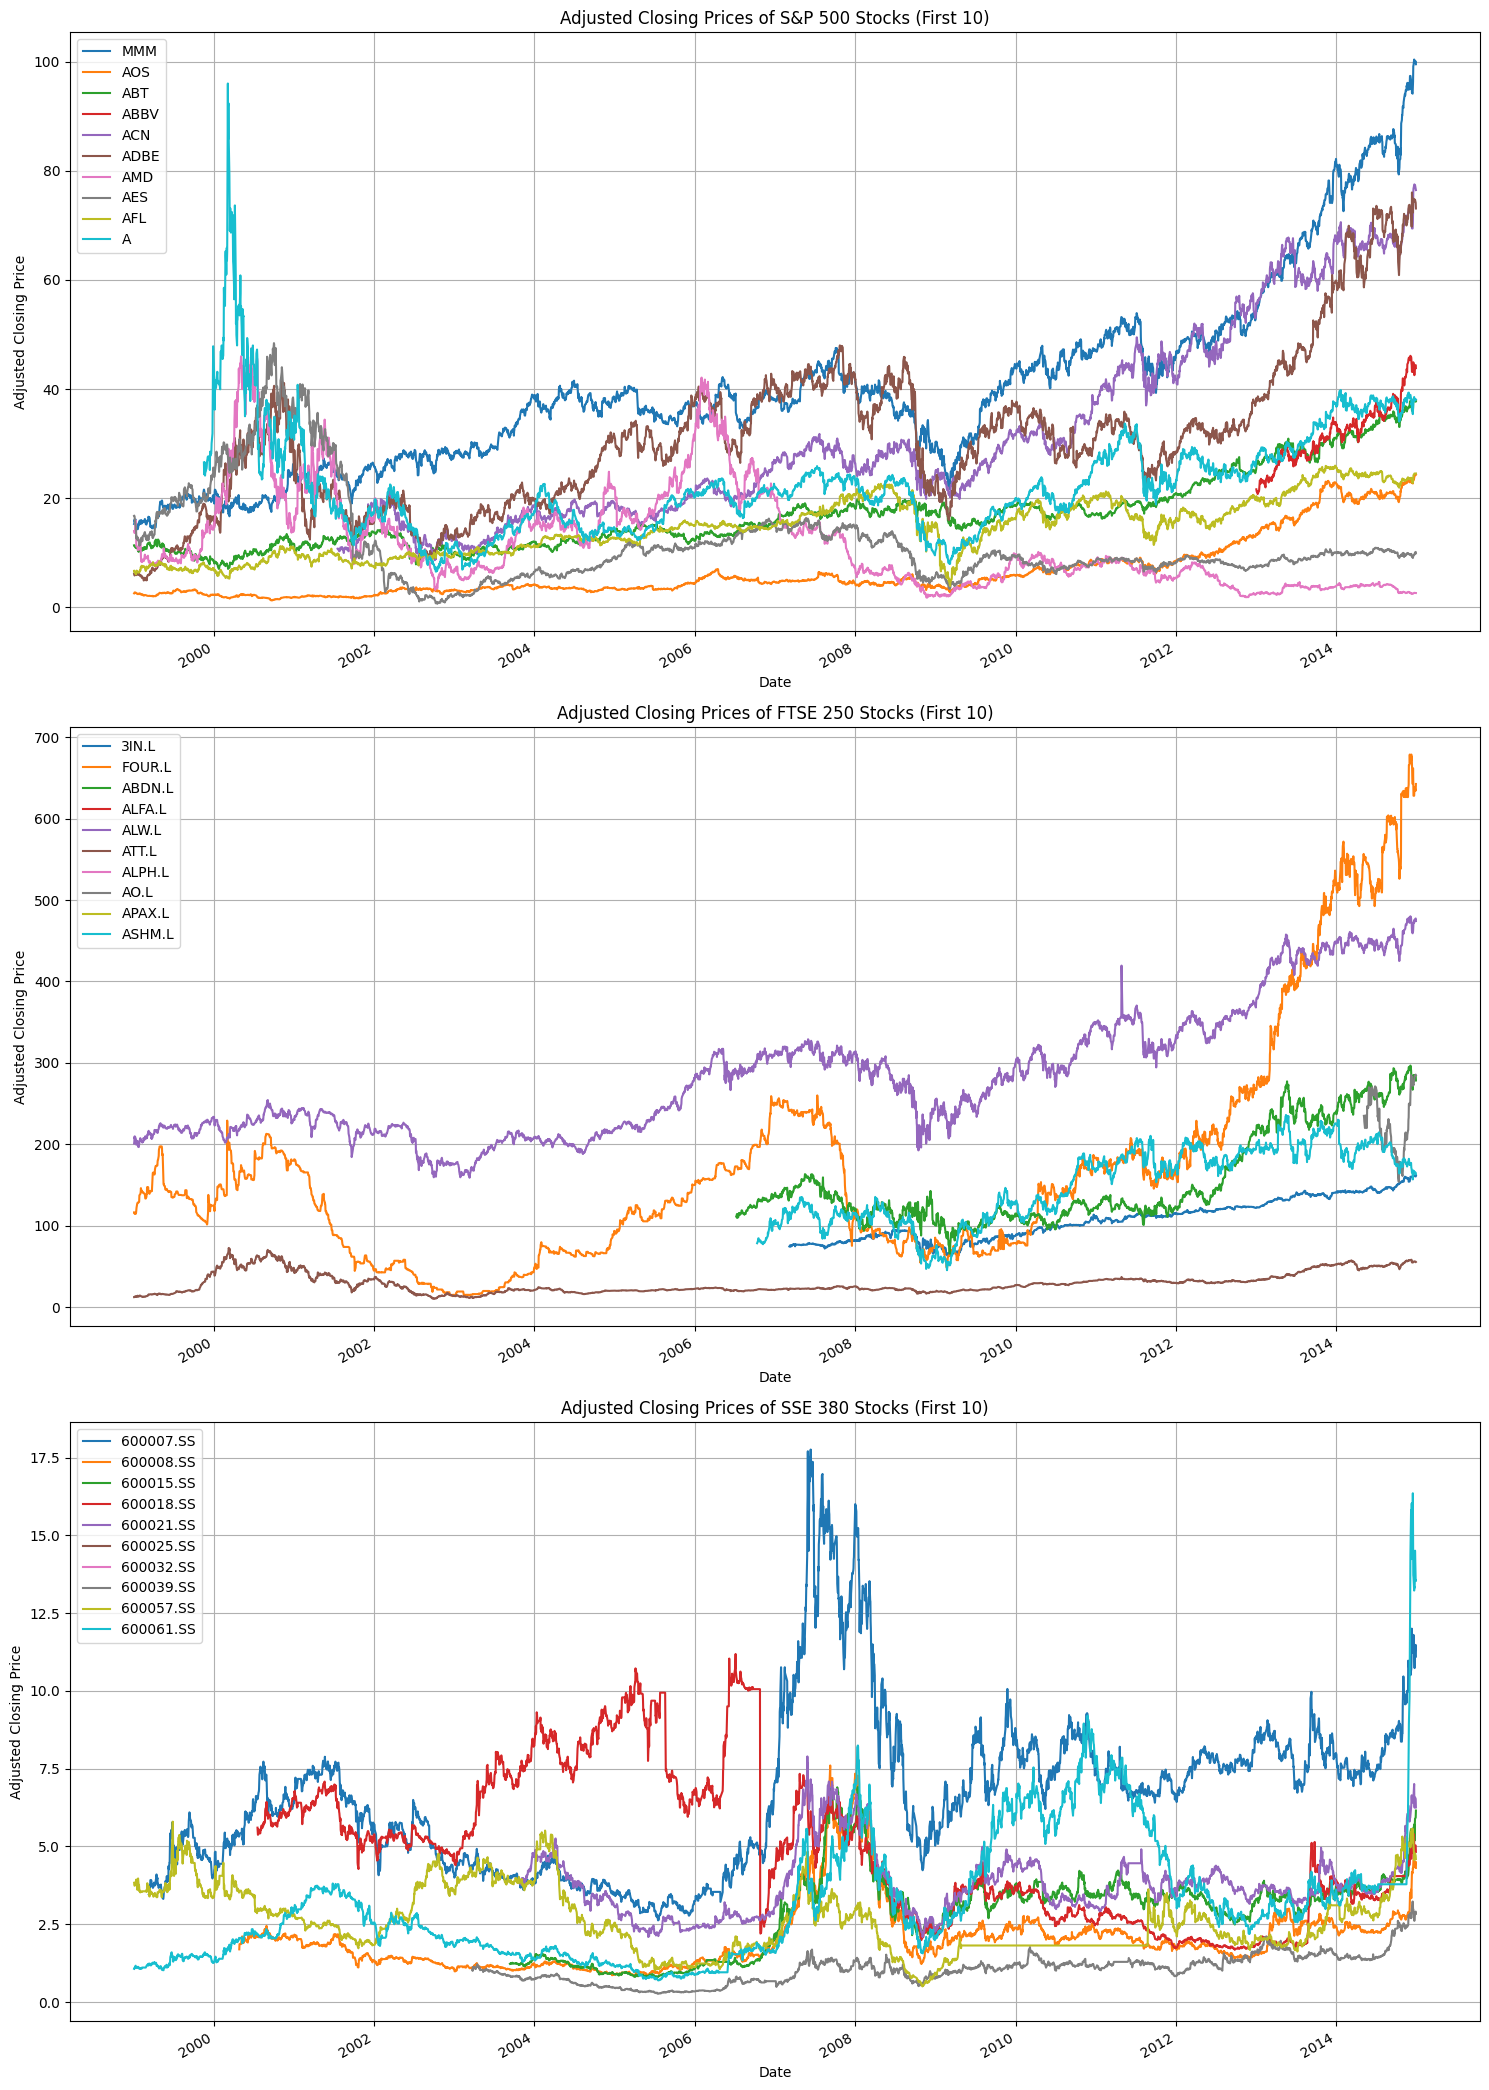

In [3]:
# Visualizing the data

# Create a 3-row subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 21))

# Plot data for each index on a separate subplot
all_sp500_data_df.iloc[:, :10].plot(ax=axes[0], title="Adjusted Closing Prices of S&P 500 Stocks (First 10)")
all_ftse250_data_df.iloc[:, :10].plot(ax=axes[1], title="Adjusted Closing Prices of FTSE 250 Stocks (First 10)")
all_sse380_data_df.iloc[:, :10].plot(ax=axes[2], title="Adjusted Closing Prices of SSE 380 Stocks (First 10)")

# Add common labels and grid
for ax in axes:
    ax.set_xlabel("Date")
    ax.set_ylabel("Adjusted Closing Price")
    ax.grid(True)

plt.tight_layout()
plt.show()


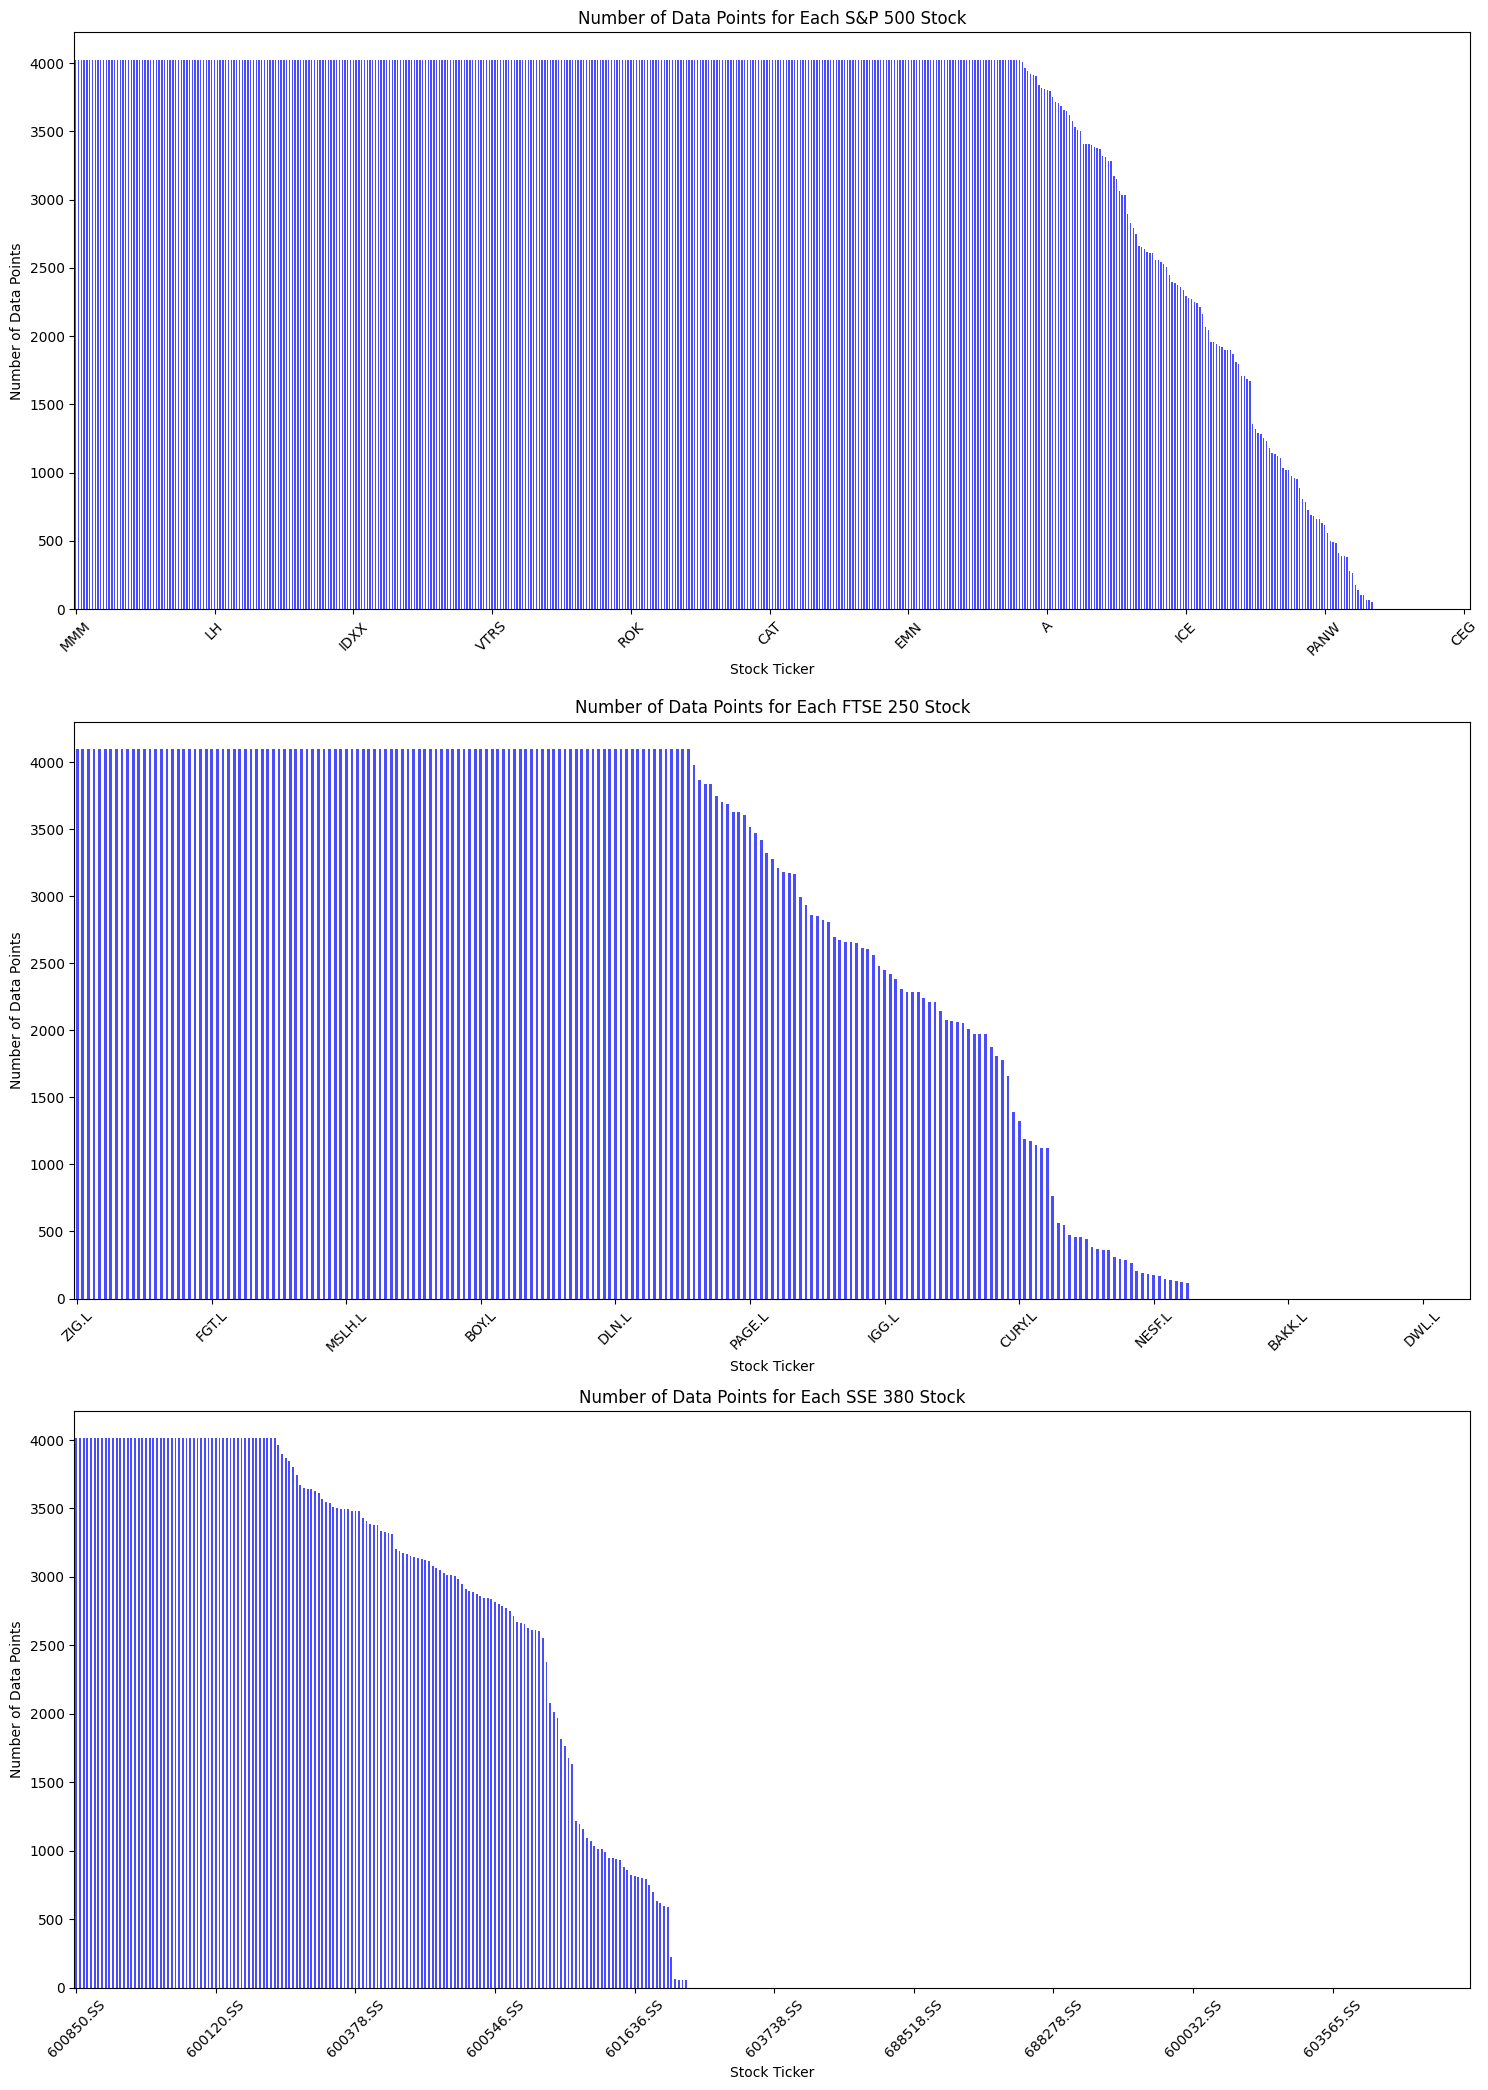

In [4]:
# Create a 3-row subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 21))

# Function to plot column lengths in a subplot
def subplot_column_lengths(df, ax, title):
    column_lengths = df.count()
    sorted_column_lengths = column_lengths.sort_values(ascending=False)
    sorted_column_lengths.plot(kind='bar', ax=ax, color='blue', alpha=0.7)
    ax.set_title(title)
    ax.set_ylabel("Number of Data Points")
    ax.set_xlabel("Stock Ticker")

    # Optional: Display only a subset of tickers on the x-axis for clarity
    ax.set_xticks(list(range(0, len(sorted_column_lengths), int(len(sorted_column_lengths)/10))))
    ax.set_xticklabels(sorted_column_lengths.index[::int(len(sorted_column_lengths)/10)], rotation=45)
    
# Plotting for each index in subplots
subplot_column_lengths(all_sp500_data_df, axes[0], "Number of Data Points for Each S&P 500 Stock")
subplot_column_lengths(all_ftse250_data_df, axes[1], "Number of Data Points for Each FTSE 250 Stock")
subplot_column_lengths(all_sse380_data_df, axes[2], "Number of Data Points for Each SSE 380 Stock")

plt.tight_layout()
plt.show()


Number of columns after filtering: 394
Number of columns after filtering: 143
Number of columns after filtering: 128


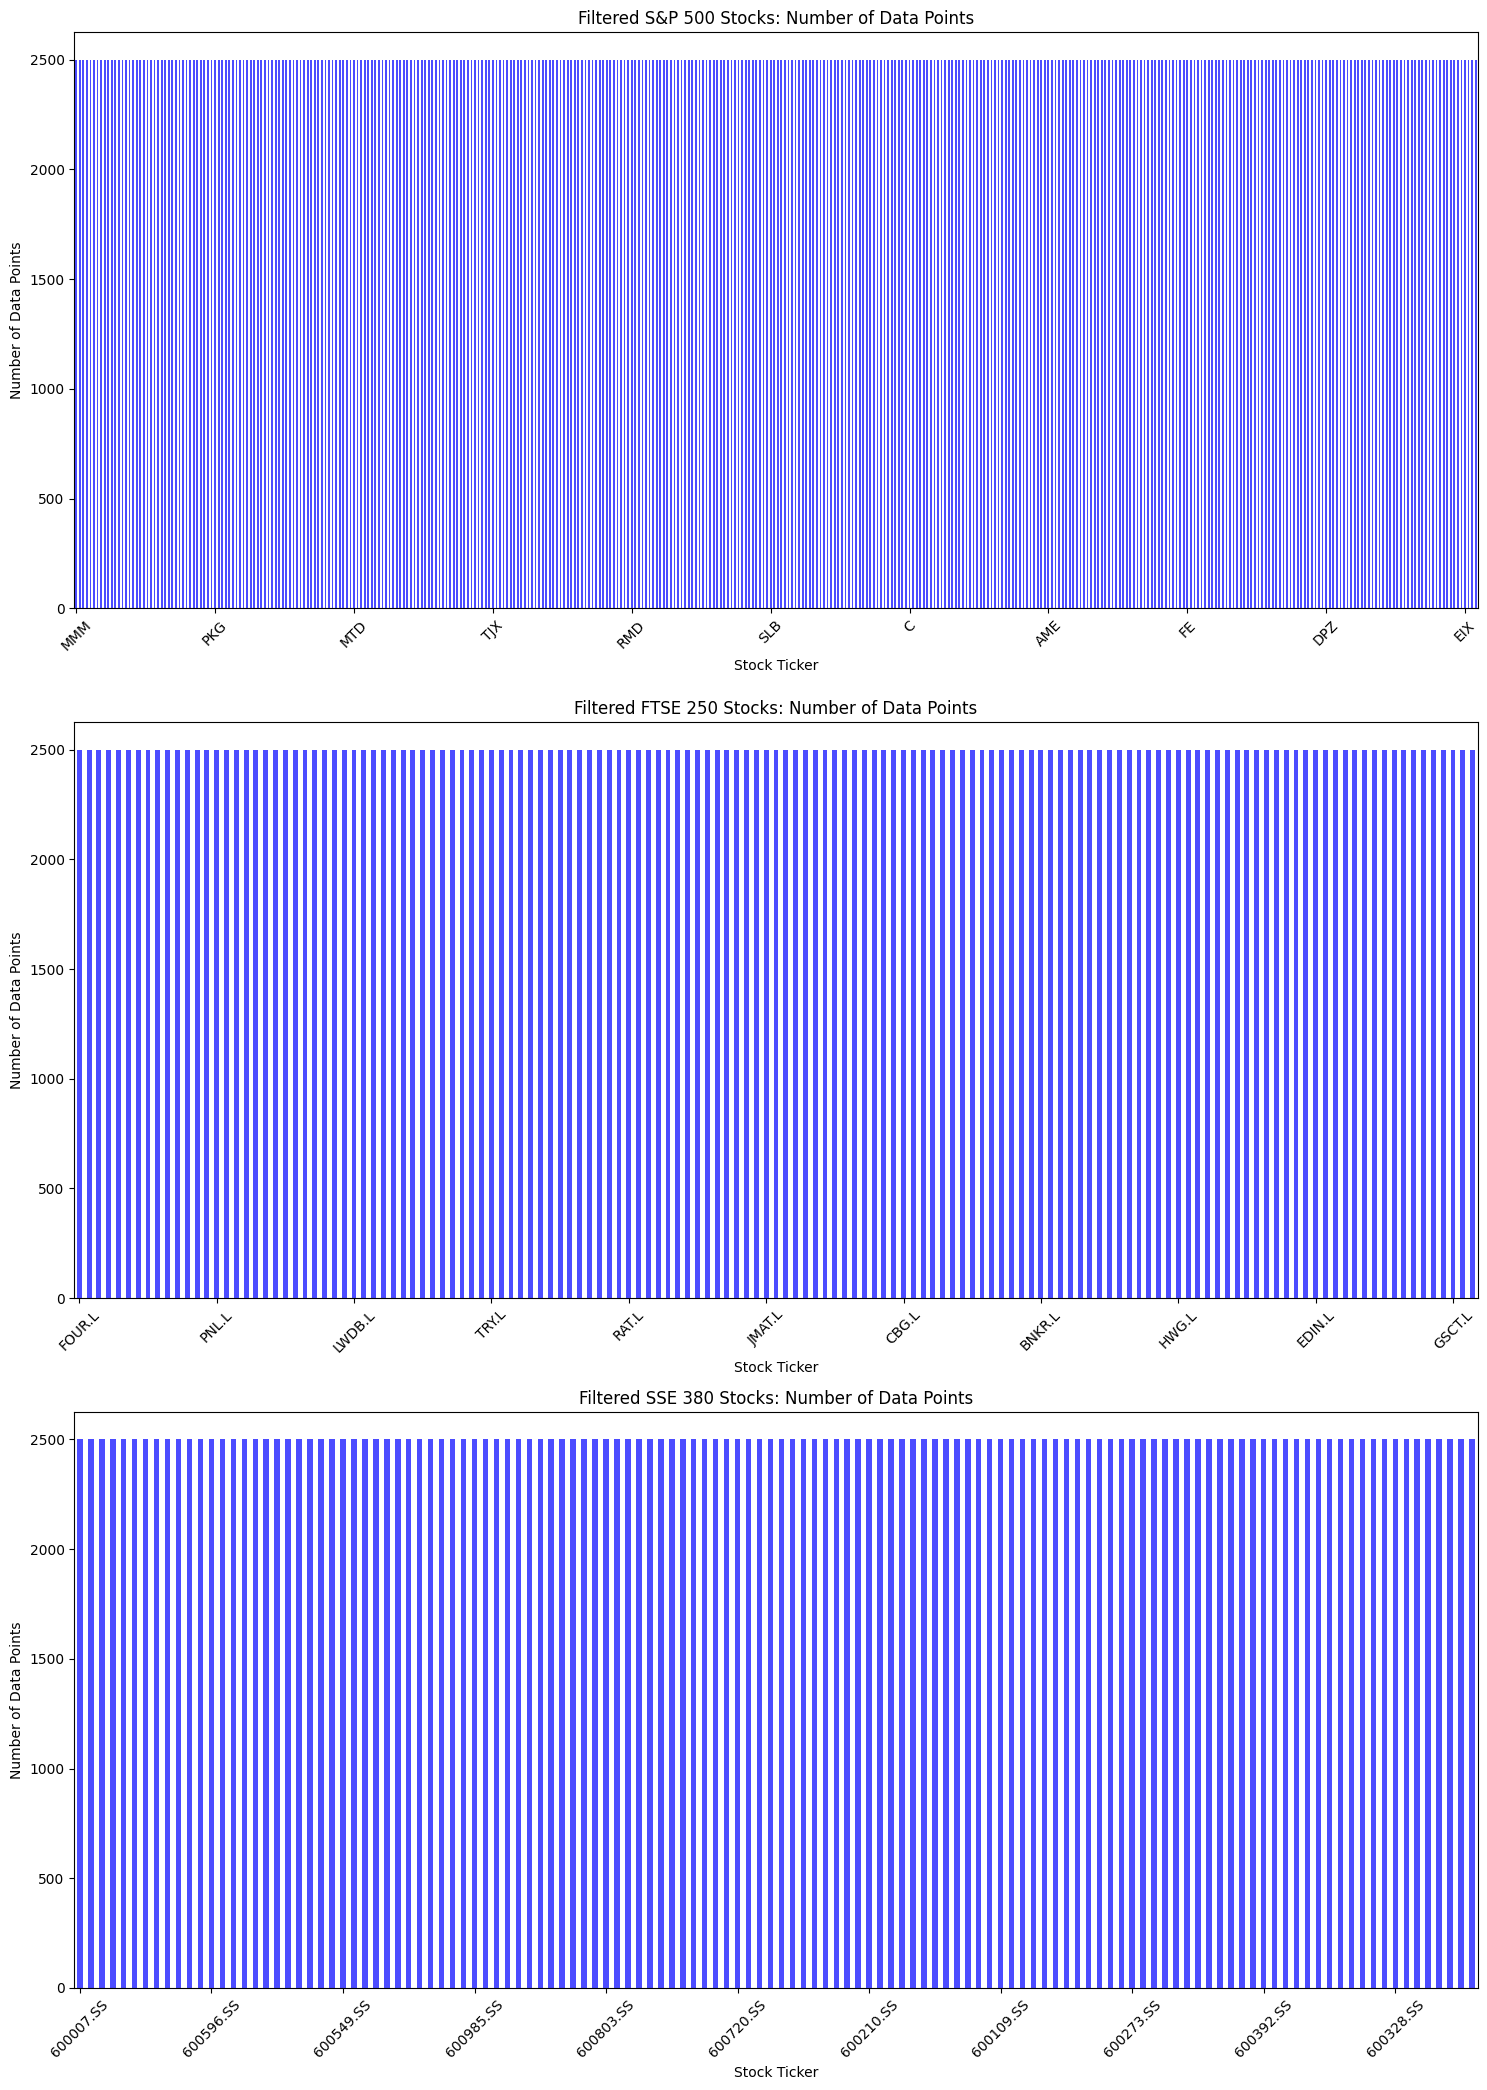

In [5]:
# Function to filter and plot data for each index
def filter_and_plot(df, ax, title):
    # Compute the count of non-NAN values for each column
    column_lengths = df.count()
    
    # Filter columns that have at least 2500 data points
    filtered_df = df.loc[:, column_lengths >= 2500]
    print(f"Number of columns after filtering: {filtered_df.shape[1]}")
    
    # Truncate the data to 2500 points
    truncated_df = filtered_df.iloc[-2500:]
    
    # Count the non-NA values for each truncated column for visualization
    truncated_column_lengths = truncated_df.count()
    
    # Sort the tickers by their lengths for visualization
    sorted_column_lengths = truncated_column_lengths.sort_values(ascending=False)
    
    # Plotting
    sorted_column_lengths.plot(kind='bar', ax=ax, color='blue', alpha=0.7)
    ax.set_title(title)
    ax.set_ylabel("Number of Data Points")
    ax.set_xlabel("Stock Ticker")
    
    # Optional: Display only a subset of tickers on the x-axis for clarity
    ax.set_xticks(list(range(0, len(sorted_column_lengths), int(len(sorted_column_lengths)/10))))
    ax.set_xticklabels(sorted_column_lengths.index[::int(len(sorted_column_lengths)/10)], rotation=45)

# Create a 3-row subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 21))

# Plotting for each index
filter_and_plot(all_sp500_data_df, axes[0], "Filtered S&P 500 Stocks: Number of Data Points")
filter_and_plot(all_ftse250_data_df, axes[1], "Filtered FTSE 250 Stocks: Number of Data Points")
filter_and_plot(all_sse380_data_df, axes[2], "Filtered SSE 380 Stocks: Number of Data Points")

plt.tight_layout()
plt.show()


In [6]:
display(filtered_sp500_data_df)

NameError: name 'filtered_sp500_data_df' is not defined

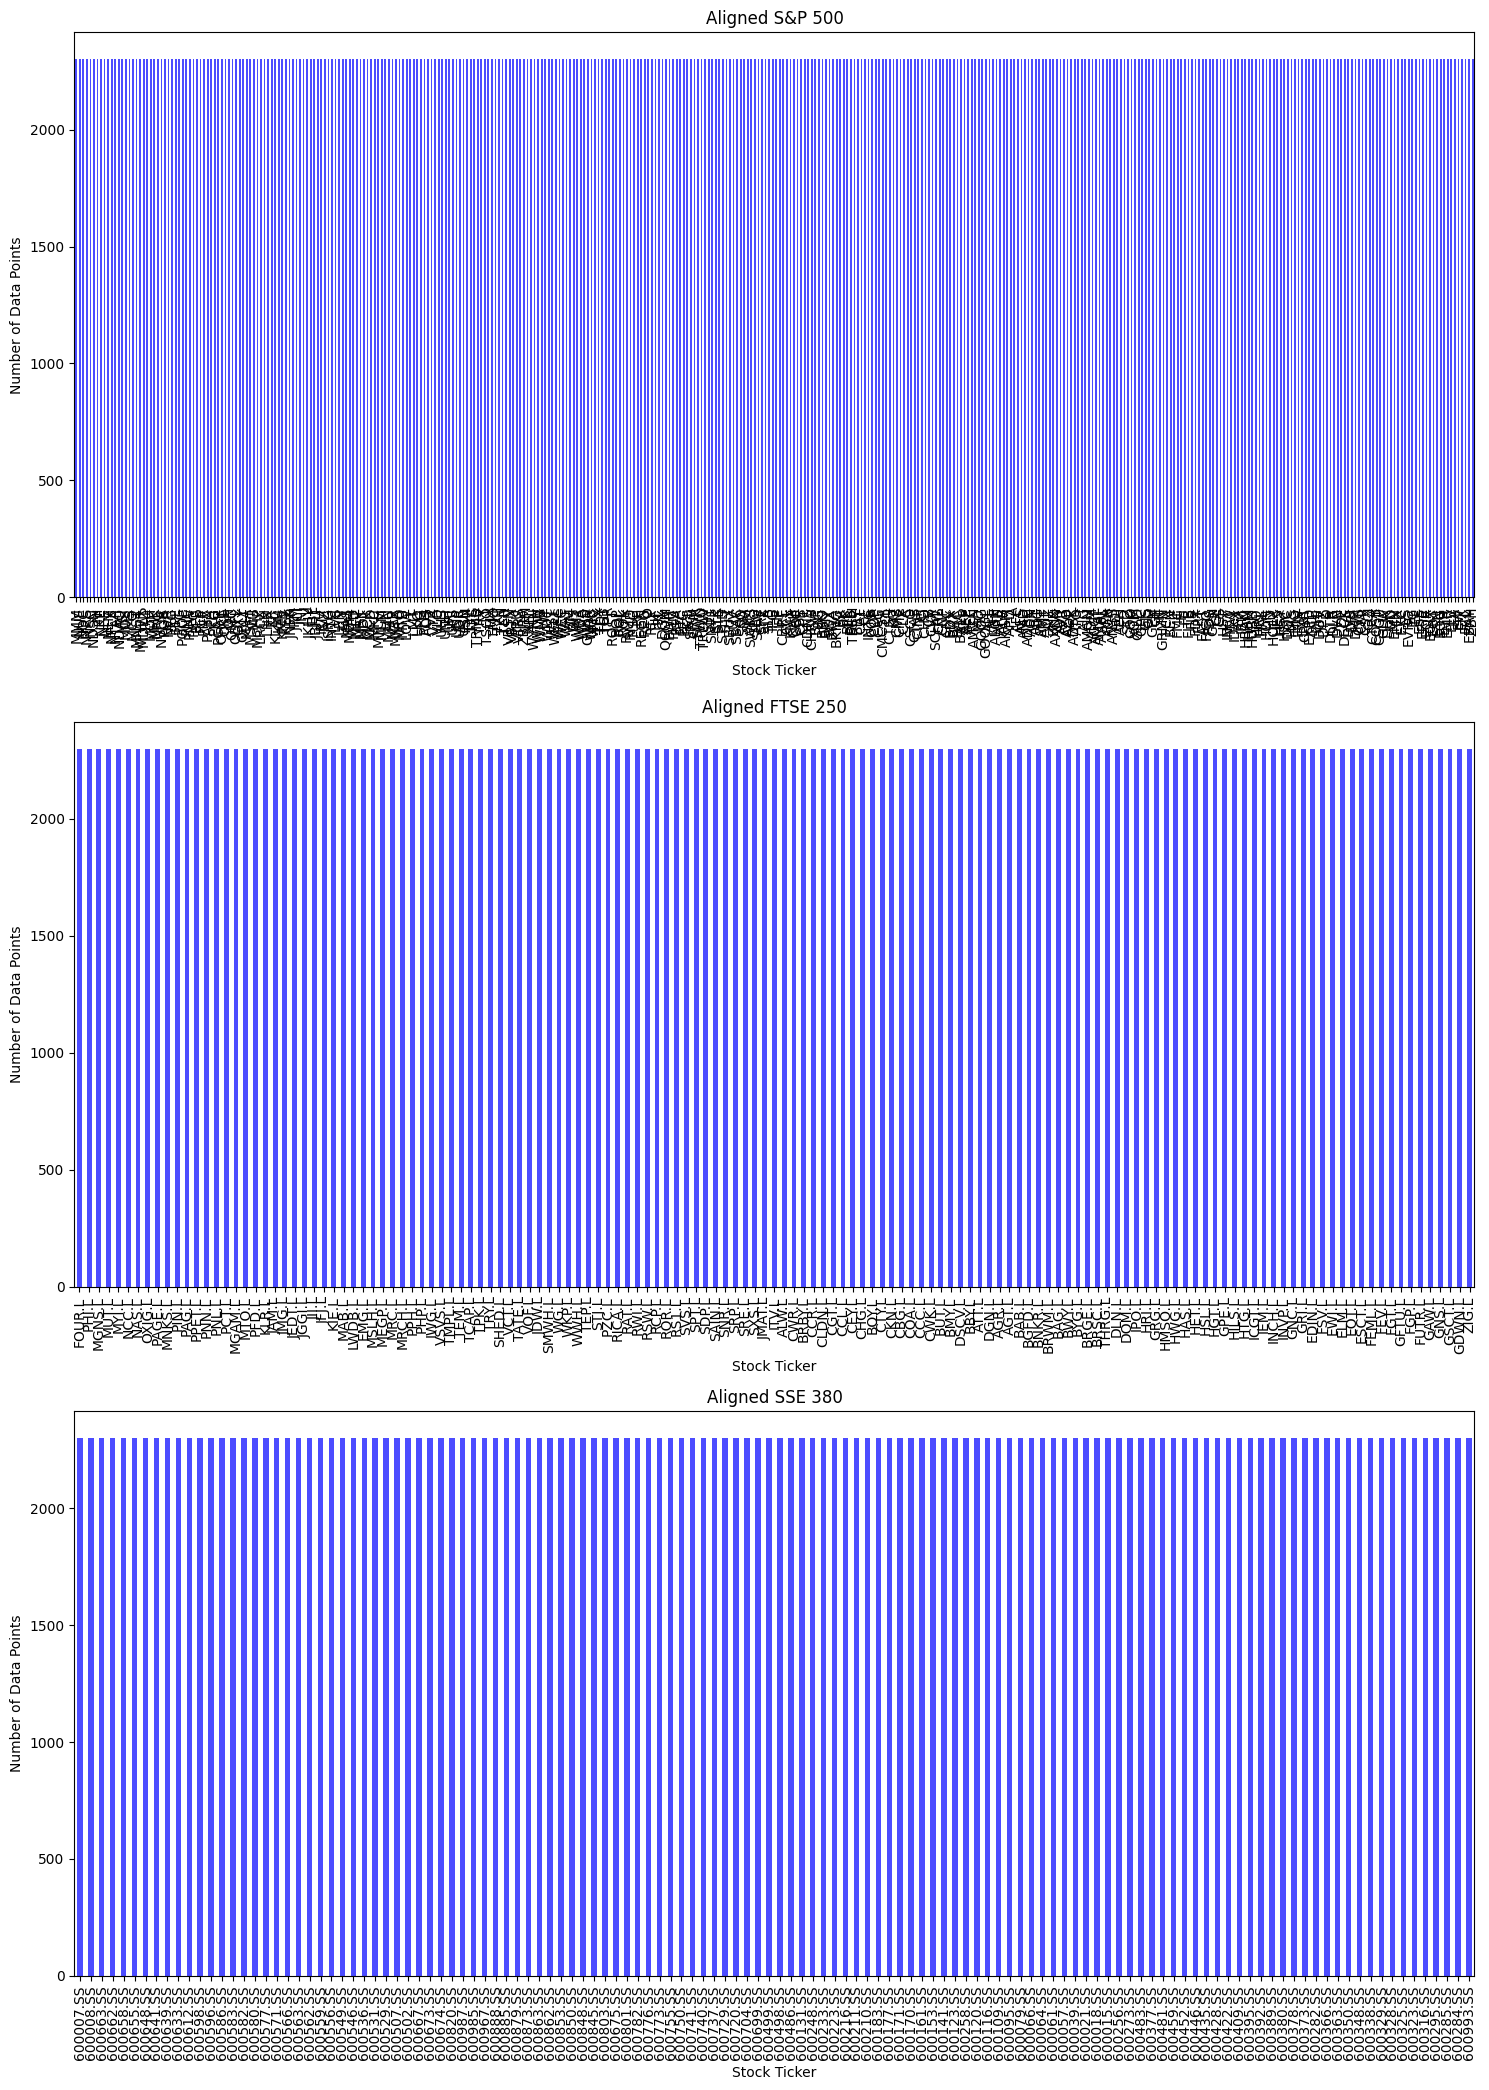

In [11]:
# Function to filter and truncate the dataframe
def filter_and_truncate(df):
    # Compute the count of non-NAN values for each column
    column_lengths = df.count()
    
    # Filter columns that have at least 2500 data points
    filtered_df = df.loc[:, column_lengths >= 2500]
    
    # Truncate the data to 2500 points (if needed)
    truncated_df = filtered_df.iloc[-2500:]
    
    return truncated_df

# Truncate and filter each original dataframe
filtered_sp500_data_df = filter_and_truncate(all_sp500_data_df)
filtered_ftse250_data_df = filter_and_truncate(all_ftse250_data_df)
filtered_sse380_data_df = filter_and_truncate(all_sse380_data_df)

# Find the common dates across all three dataframes
common_dates = filtered_sp500_data_df.index.intersection(filtered_ftse250_data_df.index).intersection(filtered_sse380_data_df.index)

# Filter each dataframe to only include these common dates
aligned_sp500_data_df = filtered_sp500_data_df.loc[common_dates]
aligned_ftse250_data_df = filtered_ftse250_data_df.loc[common_dates]
aligned_sse380_data_df = filtered_sse380_data_df.loc[common_dates]

# Now you can plot or analyze these aligned dataframes.
# For example, let's plot the count of non-NA values for each column in each aligned dataframe.

fig, axes = plt.subplots(3, 1, figsize=(15, 21))

for i, (df, title) in enumerate(zip([aligned_sp500_data_df, aligned_ftse250_data_df, aligned_sse380_data_df],
                                    ["Aligned S&P 500", "Aligned FTSE 250", "Aligned SSE 380"])):
    ax = axes[i]
    column_lengths = df.count()
    sorted_column_lengths = column_lengths.sort_values(ascending=False)
    sorted_column_lengths.plot(kind='bar', ax=ax, color='blue', alpha=0.7)
    ax.set_title(title)
    ax.set_ylabel("Number of Data Points")
    ax.set_xlabel("Stock Ticker")

plt.tight_layout()
plt.show()


### **Data Preprocessing and State Sequence Generation**

We analyze financial market data from three major stock indices: S&P 500 (US), FTSE 350 (UK), and SSE 380 (China). After filtering out stocks with insufficient data, we have datasets containing 401, 264, and 295 stocks, respectively. The goal is to process these datasets to generate the spin configurations $s_i(t)$ required for the Ising model inference.

**1. Computing Logarithmic Returns**

For each stock $i$, we calculate the logarithmic return $r_i(t)$ at time $t$ using the adjusted closing prices $p_i(t)$:

$$
r_i(t) = \ln(p_i(t+1)) - \ln(p_i(t)).
$$

**2. Binarizing Returns into Spin States**

We binarize the logarithmic returns to obtain the spin state $s_i(t)$ for each stock:

$$
s_i(t) = \begin{cases} 
1, & \text{if } r_i(t) \geq 0; \\ 
-1, & \text{if } r_i(t) < 0.
\end{cases}
$$

**3. Computing Mean Magnetizations and Covariance Matrix**

We compute the mean magnetization $m_i$ and the covariance matrix $C$ of the binary state sequences $s_i(t)$:

- **Mean Magnetizations**:

$$
m_i = \langle s_i \rangle = \frac{1}{T} \sum_{t=1}^{T} s_i(t),
$$

where $T$ is the total number of time points.

- **Covariance Matrix**:

$$
C_{ij} = \langle s_i s_j \rangle - m_i m_j = \frac{1}{T} \sum_{t=1}^{T} s_i(t) s_j(t) - m_i m_j.
$$

**4. Computing Statistical Moments of Coupling Strengths**

After inferring the coupling strengths $J_{ij}$, we compute statistical moments (mean, variance, skewness, kurtosis) to analyze their distribution:


**5. Shuffling Data to Remove Cross-Correlations**

To assess the significance of the inferred interactions, we shuffle the time series of each stock independently, which destroys any temporal and cross-correlations:


In [12]:

# Function to compute logarithmic returns
def compute_log_returns(df):
    # Take the logarithm of the adjusted closing prices
    log_prices = np.log(df)
    # Compute the returns: difference in log prices
    log_returns = log_prices.diff().iloc[1:]  # Skip the first NaN row resulting from diff()
    return log_returns

# Function to binarize the returns into +1 or -1
def binarize_returns(log_returns):
    s = log_returns.map(lambda x: 1 if x >= 0 else -1)
    return s

# Compute the mean and covariance matrix of the binary state sequences
def compute_C(s):
    T = s.shape[0]
    mean_s = s.mean(axis=0)
    E_sisj = (s.T @ s) / T
    C = E_sisj - np.outer(mean_s, mean_s)
    return C, mean_s

# Compute statistical moments of the coupling strengths
def compute_statistics(J_values):
    mean = np.mean(J_values)
    variance = np.var(J_values)
    skewness_value = skew(J_values)
    kurt = kurtosis(J_values, fisher=False)
    return mean, variance, skewness_value, kurt

# Shuffle the data to remove cross-correlations
def shuffle_data(s):
    s_shuffled = s.copy()
    for col in s_shuffled.columns:
        s_shuffled[col] = np.random.permutation(s_shuffled[col].values)
    return s_shuffled

### Analyze the correlation between the stocks

Mean Correlation: 0.6094654416715206
Median Correlation: 0.7598276245889664
Mode Correlation: -0.7985637665433788


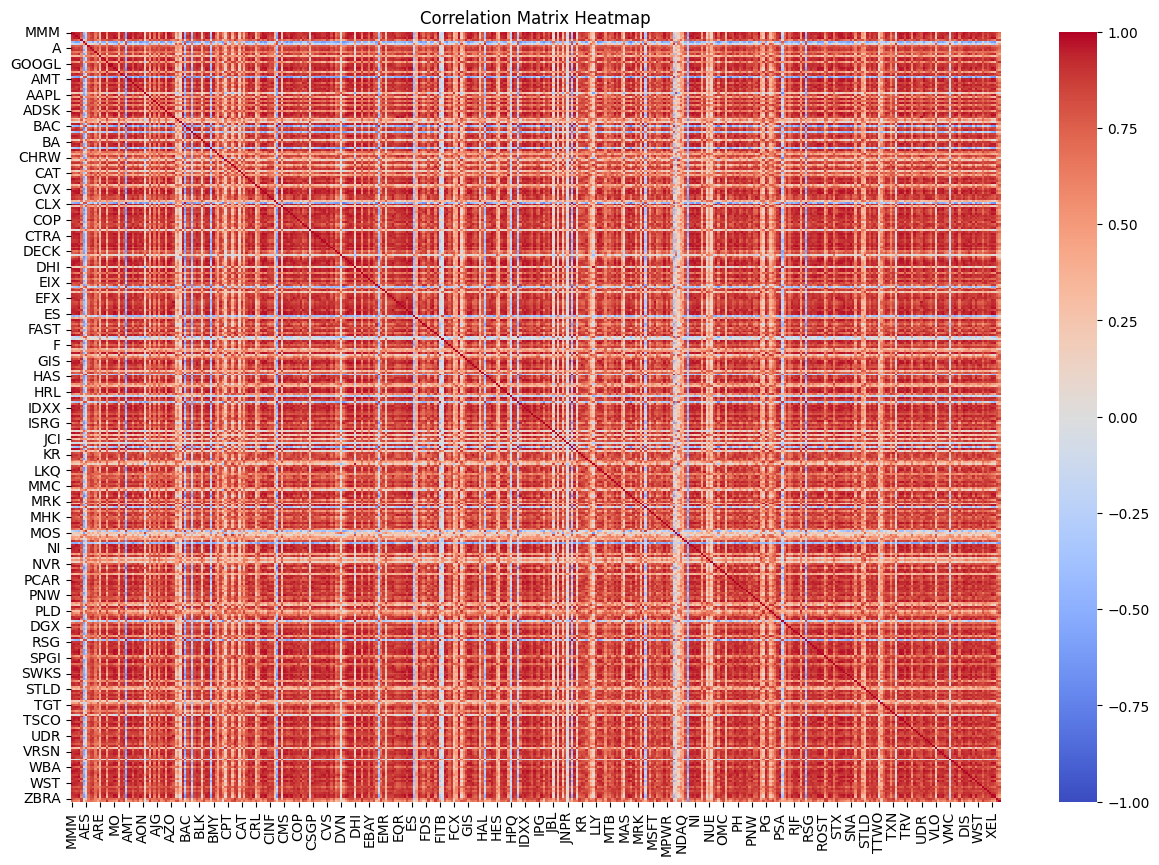

In [13]:
# Assuming filtered_sp500_data_df is your dataframe with stock data
correlation_matrix = filtered_sp500_data_df.corr()


# Extract the off-diagonal elements of the correlation matrix
off_diagonal_elements = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)]

mean_corr = np.mean(off_diagonal_elements)
median_corr = np.median(off_diagonal_elements)
mode_corr = pd.Series(off_diagonal_elements).mode()[0]  # Using Pandas to get the mode

print(f"Mean Correlation: {mean_corr}")
print(f"Median Correlation: {median_corr}")
print(f"Mode Correlation: {mode_corr}")

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()


##  Ising Model

We model financial market data using an analogy to the Ising spin model. Each stock's state is binarized to $s_i = \pm 1$, representing positive or negative returns, respectively, where $i = 1, \dots, N$ and $N$ is the number of stocks.

The **Hamiltonian** of the Ising model is given by:

$$
H(s) = -\sum_{i < j} J_{ij} s_i s_j - \sum_{i} h_i s_i,
$$

where:
- $J_{ij}$ are the **coupling strengths** between spins (stocks).
- $h_i$ are the **external fields** acting on each spin.

Our goal is to infer the coupling strengths $J_{ij}$ and external fields $h_i$ from the observed spin configurations $s_i$. 
Direct inference is computationally intensive for large systems, so we use two approximate methods:

#### **1. Naive Mean Field (nMF) Approximation**

The nMF method approximates the interactions by expanding the free energy around its mean value. The steps are:

1. **Compute Mean Magnetizations**:
   $$
   m_i = \langle s_i \rangle
   $$

2. **Compute Covariance Matrix**:
   $$
   C_{ij} = \langle s_i s_j \rangle - m_i m_j
   $$

3. **Define Diagonal Matrix $A$**:
   $$
   A_{ii} = 1 - m_i^2
   $$

4. **Compute Inverses**:
   - Inverse of $A$:
     $$
     A^{-1} = \text{diag}\left( \frac{1}{1 - m_i^2} \right)
     $$
   - Regularized Inverse of $C$:
     $$
     C^{-1} = (C + \epsilon I)^{-1}
     $$
     where $\epsilon$ is a small regularization parameter and $I$ is the identity matrix.

5. **Estimate Coupling Strengths**:
   $$
   J_{ij}^{\text{nMF}} = (A^{-1})_{ij} - (C^{-1})_{ij}
   $$

6. **Estimate External Fields**:
   $$
   h_i^{\text{nMF}} = \tanh^{-1}(m_i) - \sum_{j} J_{ij}^{\text{nMF}} m_j
   $$

#### **2. Thouless-Anderson-Palmer (TAP) Approximation**

The TAP method includes higher-order corrections for better accuracy. The steps are:

1. **Compute Inverse Covariance Matrix**:
   $$
   C^{-1} = (C + \epsilon I)^{-1}
   $$

2. **Compute Discriminant Matrix**:
   $$
   D_{ij} = 1 - 8 (C^{-1})_{ij} m_i m_j
   $$
   - Set any negative values in $D_{ij}$ to zero to avoid numerical issues.

3. **Compute Coupling Strengths**:
   $$
   J_{ij}^{\text{TAP}} = \frac{-2 (C^{-1})_{ij}}{1 + \sqrt{D_{ij}}}
   $$

4. **Compute External Fields**:
   $$
   h_i^{\text{TAP}} = h_i^{\text{nMF}} - m_i \sum_{j} (J_{ij}^{\text{TAP}})^2 (1 - m_j^2)
   $$

In [14]:
# Compute the interaction strengths using the Naive Mean Field method
def compute_J_nMF(C, mean_s):
    A_diag = 1 - mean_s**2
    A_inv = np.diag(1 / A_diag)
    # Regularize the covariance matrix to ensure it's invertible
    epsilon = 1e-9
    C_reg = C + epsilon * np.eye(C.shape[0])
    C_inv = np.linalg.inv(C_reg)
    #C_inv = np.linalg.inv(C)
    J_nMF = A_inv - C_inv
    return J_nMF

# Compute the external fields using the Naive Mean Field method
def compute_h_nMF(J, mean_s):
    #epsilon = 1e-9
    epsilon = 0
    mean_s = np.clip(mean_s, -1 + epsilon, 1 - epsilon)
    h = np.arctanh(mean_s) - J @ mean_s
    return h

# Compute the interaction strengths using the TAP approximation
def compute_J_TAP(C_inv, mean_s):
    m_i = mean_s
    M = np.outer(m_i, m_i)
    discriminant = 1 - 8 * C_inv * M
    discriminant[discriminant < 0] = 0  # Handle small negative values due to numerical errors
    sqrt_term = np.sqrt(discriminant)
    denominator = 1 + sqrt_term
    #denominator[denominator == 0] = np.finfo(float).eps  # Avoid division by zero
    J_TAP = (-2 * C_inv) / denominator
    return J_TAP

# Compute the external fields using the TAP approximation
def compute_h_TAP(h_nMF, J_TAP, mean_s):
    m_i = mean_s
    one_minus_mj2 = 1 - mean_s**2
    J_TAP_squared = J_TAP**2
    correction = m_i * (J_TAP_squared @ one_minus_mj2)
    h_TAP = h_nMF - correction
    return h_TAP

# Extract the upper triangle values of the interaction matrix
def get_upper_triangle_values(J):
    upper_tri_indices = np.triu_indices_from(J, k=1)
    J_values = J[upper_tri_indices]
    return J_values

### Compute the Coupling Strengths and External Fields

We remove stocks with very large or very small coupling strengths and external fields to filter out outliers by removing the top and bottom 5% of values. 
This filtering makes the results more applicable to the general market condition and stocks.

We also compute the statistical moments (mean, variance, skewness, kurtosis) of the coupling strengths and external fields to analyze their distribution.

### Shuffle Data for Significance Testing

To assess the significance of the inferred interactions, we shuffle the time series of each stock independently, which destroys any temporal and cross-correlations. We then recompute the coupling strengths and external fields using the shuffled data.


### Coupling Strength Distribution Analysis

We explore the distributions of the coupling strengths $J_{ij}$ derived from the Naive Mean Field (nMF) and TAP approximations by plotting histograms for each market. By comparing the original data with shuffled data, we assess the significance of the inferred interactions—where the original data captures genuine market correlations, and the shuffled data represents random chance. The histograms reveal how coupling strengths are distributed, indicating the prevalence and magnitude of stock interactions. Filtering out extreme values (outliers) ensures that the analysis focuses on typical interactions, improving the reliability of statistical measures like mean, variance, skewness, and kurtosis. The accompanying statistical table summarizes these moments, providing a quantitative comparison between the approximations and highlighting the impact of actual market structure versus random fluctuations.

Processing S&P 500 data...
Condition number of covariance matrix: 1.32e+04
Condition number after regularization: 1.32e+04
No. of extreme values removed: 78
Finished processing S&P 500 data.

Processing FTSE 250 data...
Condition number of covariance matrix: 9.96e+01
Condition number after regularization: 9.95e+01
No. of extreme values removed: 12
Finished processing FTSE 250 data.

Processing SSE 380 data...
Condition number of covariance matrix: 1.24e+02
Condition number after regularization: 1.24e+02
No. of extreme values removed: 10
Finished processing SSE 380 data.



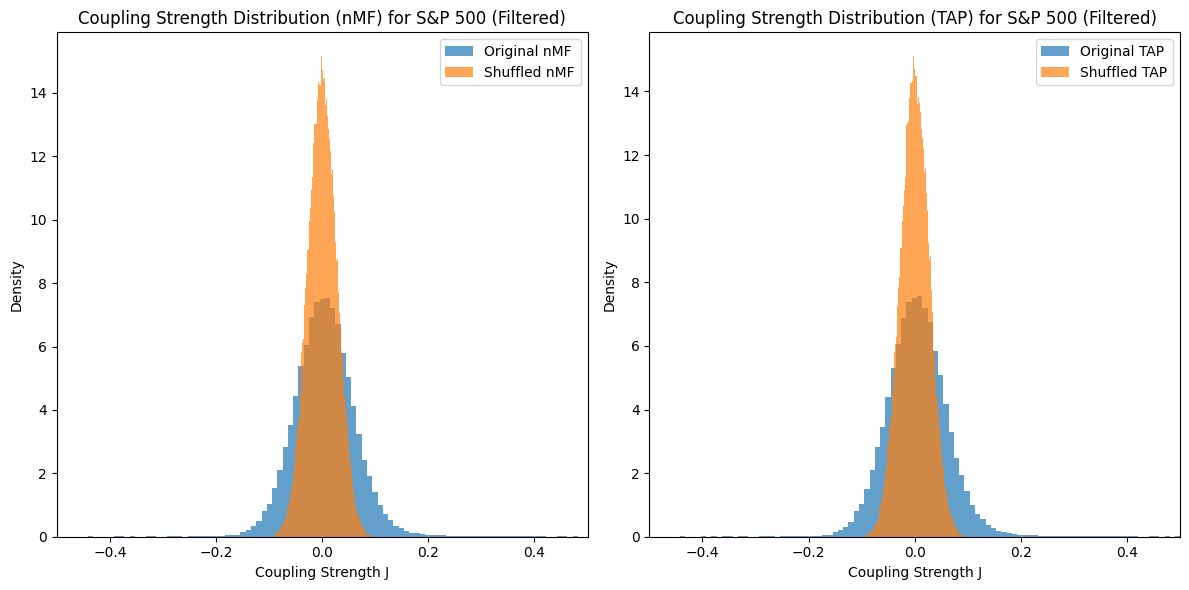

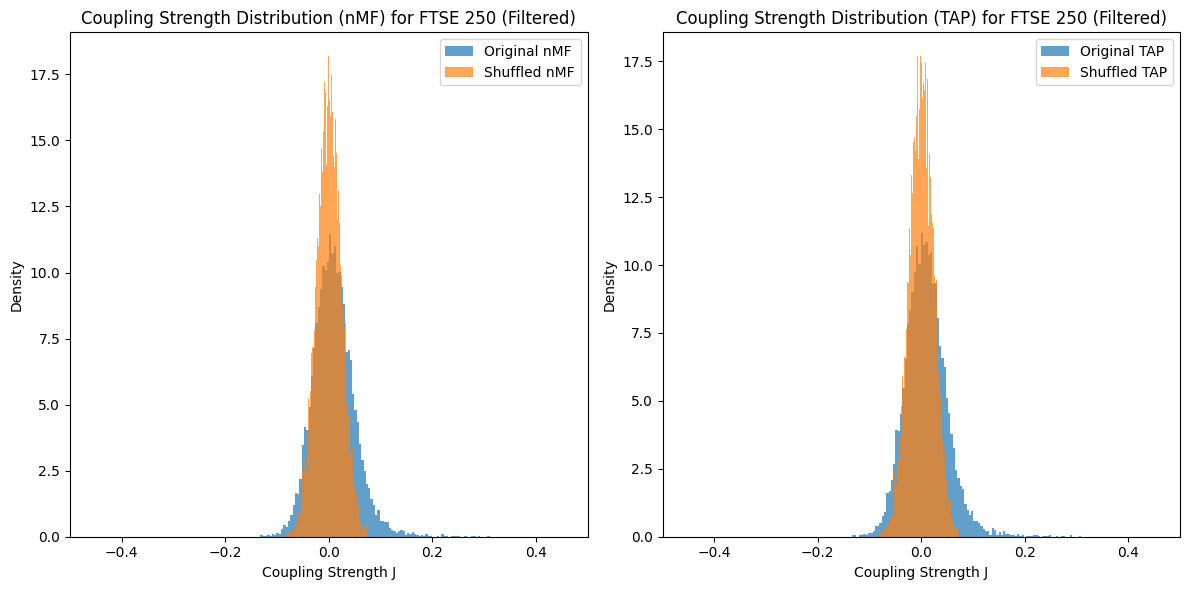

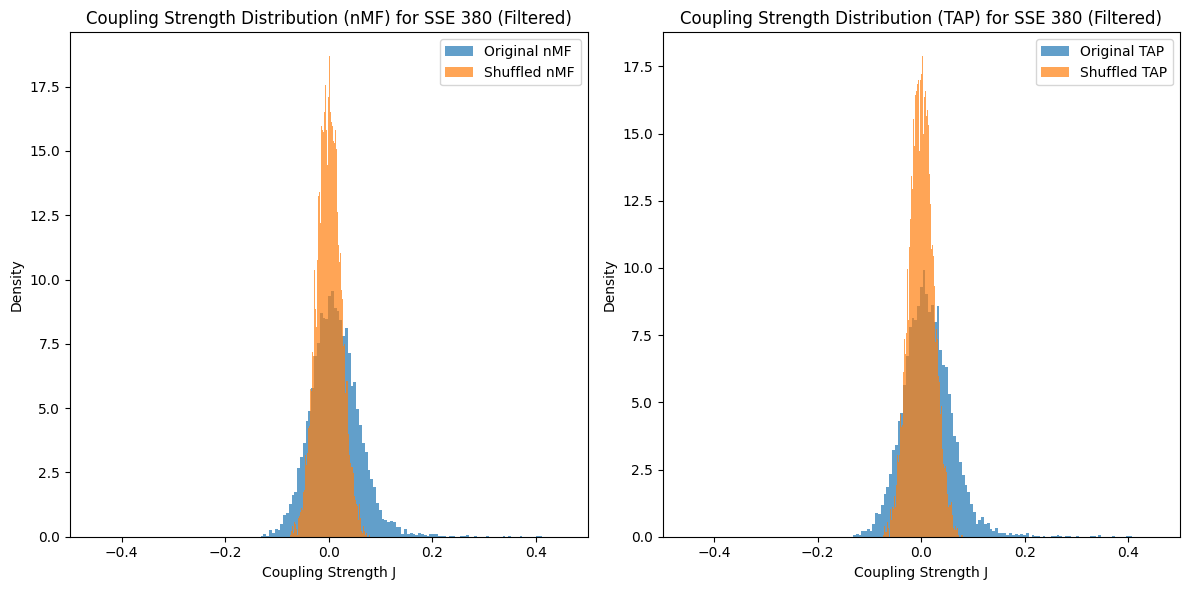

     Market     Mean (nMF) Variance (nMF) Skewness (nMF) Kurtosis (nMF)  \
0   S&P 500  0.0052;0.0000  0.0037;0.0008     0.64;-0.00      9.77;2.91   
1  FTSE 250  0.0097;0.0003  0.0017;0.0006     0.80;-0.01      6.01;2.93   
2   SSE 380  0.0126;0.0001  0.0023;0.0005      0.88;0.02      7.13;2.93   

      Mean (TAP) Variance (TAP) Skewness (TAP) Kurtosis (TAP)  
0  0.0052;0.0000  0.0037;0.0008     0.64;-0.01      9.75;2.91  
1  0.0096;0.0003  0.0017;0.0006     0.78;-0.01      5.92;2.93  
2  0.0125;0.0001  0.0022;0.0005      0.85;0.02      6.89;2.93  


In [15]:
# List of dataframes and their names
dataframes = [
    (aligned_sp500_data_df, "S&P 500"),
    (aligned_ftse250_data_df, "FTSE 250"),
    (aligned_sse380_data_df, "SSE 380")
]

# Prepare dictionaries to store results
results = {}

# Loop over each dataframe
for df, name in dataframes:
    print(f"Processing {name} data...")
    # Compute log returns
    log_returns = compute_log_returns(df)
    # Binarize returns
    s = binarize_returns(log_returns)
    # Remove columns with zero variance
    std_s = s.std(axis=0)
    columns_to_keep = std_s[std_s > 0].index
    s = s[columns_to_keep]
    # Update df to keep only the columns with non-zero variance
    df = df[columns_to_keep]
    # Compute covariance matrix and mean
    C, mean_s = compute_C(s)
    # Regularize covariance matrix
    condition_number = np.linalg.cond(C)
    print(f"Condition number of covariance matrix: {condition_number:.2e}")
    epsilon = 1e-5  # Use a small regularization parameter
    C_reg = C + epsilon * np.eye(C.shape[0])
    print(f"Condition number after regularization: {np.linalg.cond(C_reg):.2e}")
    # Compute interaction strengths and external fields using nMF
    try:
        J_nMF = compute_J_nMF(C_reg, mean_s)
    except np.linalg.LinAlgError:
        print(f"Covariance matrix is singular for {name}, using pseudo-inverse.")
        C_inv = np.linalg.pinv(C_reg)
        A_diag = 1 - mean_s**2
        A_inv = np.diag(1 / A_diag)
        J_nMF = A_inv - C_inv
    h_nMF = compute_h_nMF(J_nMF, mean_s)
    # Compute interaction strengths and external fields using TAP
    try:
        C_inv = np.linalg.inv(C_reg)
    except np.linalg.LinAlgError:
        print(f"C_reg is singular for {name}, using pseudo-inverse.")
        C_inv = np.linalg.pinv(C_reg)
    J_TAP = compute_J_TAP(C_inv, mean_s)
    h_TAP = compute_h_TAP(h_nMF, J_TAP, mean_s)
    # Extract coupling strengths
    J_nMF_values = get_upper_triangle_values(J_nMF)
    J_TAP_values = get_upper_triangle_values(J_TAP)
    # Apply filtering to coupling strengths
    percentiles = np.percentile(J_nMF_values, [0.05, 99.95])
    lower_percentile = percentiles[0]
    upper_percentile = percentiles[1]
    # Filter out extreme values
    J_nMF_values_filtered = J_nMF_values[(J_nMF_values >= lower_percentile) & (J_nMF_values <= upper_percentile)]
    print(f"No. of extreme values removed: {J_nMF_values.shape[0] - J_nMF_values_filtered.shape[0]}")
    # Compute statistics on filtered data
    stats_nMF_filtered = compute_statistics(J_nMF_values_filtered)
    # Similarly for J_TAP_values
    percentiles_TAP = np.percentile(J_TAP_values, [0.05, 99.95])
    lower_percentile_TAP = percentiles_TAP[0]
    upper_percentile_TAP = percentiles_TAP[1]
    J_TAP_values_filtered = J_TAP_values[(J_TAP_values >= lower_percentile_TAP) & (J_TAP_values <= upper_percentile_TAP)]
    stats_TAP_filtered = compute_statistics(J_TAP_values_filtered)
    # Store results
    results[name] = {
        's': s,
        'mean_s': mean_s,
        'C': C,
        'J_nMF': J_nMF,
        'h_nMF': h_nMF,
        'J_TAP': J_TAP,
        'h_TAP': h_TAP,
        'J_nMF_values': J_nMF_values,
        'J_TAP_values': J_TAP_values,
        'J_nMF_values_filtered': J_nMF_values_filtered,
        'J_TAP_values_filtered': J_TAP_values_filtered,
        'stats_nMF': stats_nMF_filtered,
        'stats_TAP': stats_TAP_filtered,
    }
    # Shuffle the data and repeat the analysis for comparison
    s_shuffled = shuffle_data(s)
    C_shuffled, mean_s_shuffled = compute_C(s_shuffled)
    # Regularize the shuffled covariance matrix
    C_shuffled_reg = C_shuffled + epsilon * np.eye(C_shuffled.shape[0])
    try:
        J_nMF_shuffled = compute_J_nMF(C_shuffled_reg, mean_s_shuffled)
    except np.linalg.LinAlgError:
        C_inv_shuffled = np.linalg.pinv(C_shuffled_reg)
        A_diag_shuffled = 1 - mean_s_shuffled**2
        A_inv_shuffled = np.diag(1 / A_diag_shuffled)
        J_nMF_shuffled = A_inv_shuffled - C_inv_shuffled
    h_nMF_shuffled = compute_h_nMF(J_nMF_shuffled, mean_s_shuffled)
    # Compute interaction strengths and external fields using TAP for shuffled data
    try:
        C_inv_shuffled = np.linalg.inv(C_shuffled_reg)
    except np.linalg.LinAlgError:
        print(f"C_shuffled_reg is singular for shuffled data in {name}, using pseudo-inverse.")
        C_inv_shuffled = np.linalg.pinv(C_shuffled_reg)
    J_TAP_shuffled = compute_J_TAP(C_inv_shuffled, mean_s_shuffled)
    h_TAP_shuffled = compute_h_TAP(h_nMF_shuffled, J_TAP_shuffled, mean_s_shuffled)
    # Extract coupling strengths for shuffled data
    J_nMF_values_shuffled = get_upper_triangle_values(J_nMF_shuffled)
    J_TAP_values_shuffled = get_upper_triangle_values(J_TAP_shuffled)
    # Apply filtering to shuffled coupling strengths
    percentiles_shuffled = np.percentile(J_nMF_values_shuffled, [0.05, 99.95])
    lower_percentile_shuffled = percentiles_shuffled[0]
    upper_percentile_shuffled = percentiles_shuffled[1]
    J_nMF_values_shuffled_filtered = J_nMF_values_shuffled[(J_nMF_values_shuffled >= lower_percentile_shuffled) & (J_nMF_values_shuffled <= upper_percentile_shuffled)]
    stats_nMF_shuffled_filtered = compute_statistics(J_nMF_values_shuffled_filtered)
    # Similarly for J_TAP_values_shuffled
    percentiles_TAP_shuffled = np.percentile(J_TAP_values_shuffled, [0.05, 99.95])
    lower_percentile_TAP_shuffled = percentiles_TAP_shuffled[0]
    upper_percentile_TAP_shuffled = percentiles_TAP_shuffled[1]
    J_TAP_values_shuffled_filtered = J_TAP_values_shuffled[(J_TAP_values_shuffled >= lower_percentile_TAP_shuffled) & (J_TAP_values_shuffled <= upper_percentile_TAP_shuffled)]
    stats_TAP_shuffled_filtered = compute_statistics(J_TAP_values_shuffled_filtered)
    # Store shuffled results
    results[name]['s_shuffled'] = s_shuffled
    results[name]['mean_s_shuffled'] = mean_s_shuffled
    results[name]['C_shuffled'] = C_shuffled
    results[name]['J_nMF_shuffled'] = J_nMF_shuffled
    results[name]['h_nMF_shuffled'] = h_nMF_shuffled
    results[name]['J_TAP_shuffled'] = J_TAP_shuffled
    results[name]['h_TAP_shuffled'] = h_TAP_shuffled
    results[name]['J_nMF_values_shuffled'] = J_nMF_values_shuffled
    results[name]['J_TAP_values_shuffled'] = J_TAP_values_shuffled
    results[name]['J_nMF_values_shuffled_filtered'] = J_nMF_values_shuffled_filtered
    results[name]['J_TAP_values_shuffled_filtered'] = J_TAP_values_shuffled_filtered
    results[name]['stats_nMF_shuffled'] = stats_nMF_shuffled_filtered
    results[name]['stats_TAP_shuffled'] = stats_TAP_shuffled_filtered
    print(f"Finished processing {name} data.\n")

# Plotting the coupling strength distributions
for name in results.keys():
    J_values = results[name]['J_nMF_values_filtered']
    J_values_shuffled = results[name]['J_nMF_values_shuffled_filtered']
    J_TAP_values = results[name]['J_TAP_values_filtered']
    J_TAP_values_shuffled = results[name]['J_TAP_values_shuffled_filtered']
    plt.figure(figsize=(12, 6))
    # Make a 1x2 grid
    plt.subplot(1, 2, 1)
    plt.hist(J_values, bins=100, alpha=0.7, label='Original nMF', density=True)
    plt.hist(J_values_shuffled, bins=100, alpha=0.7, label='Shuffled nMF', density=True)
    plt.xlim(-0.5, 0.5)
    plt.title(f"Coupling Strength Distribution (nMF) for {name} (Filtered)")
    plt.xlabel("Coupling Strength J")
    plt.ylabel("Density")
    plt.legend()
    # Add a second plot for the J_TAP values
    plt.subplot(1, 2, 2)
    plt.hist(J_TAP_values, bins=100, alpha=0.7, label='Original TAP', density=True)
    plt.hist(J_TAP_values_shuffled, bins=100, alpha=0.7, label='Shuffled TAP', density=True)
    plt.xlim(-0.5, 0.5)
    plt.title(f"Coupling Strength Distribution (TAP) for {name} (Filtered)")
    plt.xlabel("Coupling Strength J")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Prepare a list to store statistical moments
stats_list = []

for name in results.keys():
    mean_nMF, var_nMF, skew_nMF, kurt_nMF = results[name]['stats_nMF']
    mean_nMF_shuffled, var_nMF_shuffled, skew_nMF_shuffled, kurt_nMF_shuffled = results[name]['stats_nMF_shuffled']
    mean_TAP, var_TAP, skew_TAP, kurt_TAP = results[name]['stats_TAP']
    mean_TAP_shuffled, var_TAP_shuffled, skew_TAP_shuffled, kurt_TAP_shuffled = results[name]['stats_TAP_shuffled']
    stats_list.append({
        'Market': name,
        'Mean (nMF)': f"{mean_nMF:.4f};{mean_nMF_shuffled:.4f}",
        'Variance (nMF)': f"{var_nMF:.4f};{var_nMF_shuffled:.4f}",
        'Skewness (nMF)': f"{skew_nMF:.2f};{skew_nMF_shuffled:.2f}",
        'Kurtosis (nMF)': f"{kurt_nMF:.2f};{kurt_nMF_shuffled:.2f}",
        'Mean (TAP)': f"{mean_TAP:.4f};{mean_TAP_shuffled:.4f}",
        'Variance (TAP)': f"{var_TAP:.4f};{var_TAP_shuffled:.4f}",
        'Skewness (TAP)': f"{skew_TAP:.2f};{skew_TAP_shuffled:.2f}",
        'Kurtosis (TAP)': f"{kurt_TAP:.2f};{kurt_TAP_shuffled:.2f}",
    })

# Create the DataFrame from the list
stats_table = pd.DataFrame(stats_list)

# Display the table
print(stats_table)


### External Field Analysis

We analyze the distributions of the external fields \( h_i \) obtained from both the Naive Mean Field (nMF) and TAP approximations for each market. The external field represents the inherent tendency of individual stocks to exhibit positive or negative returns independent of their interactions with other stocks. By plotting the histograms of these external fields, we observe the overall bias and variability in stock behaviors within each market. A distribution centered around zero suggests that stocks have no strong inherent bias toward positive or negative returns, indicating that their behavior is largely influenced by interactions with other stocks. In contrast, a distribution skewed away from zero indicates that external factors play a significant role in driving stock returns. Comparing the nMF and TAP distributions allows us to see how higher-order corrections in the TAP approximation affect the estimation of external fields, potentially providing a more accurate representation of individual stock tendencies.

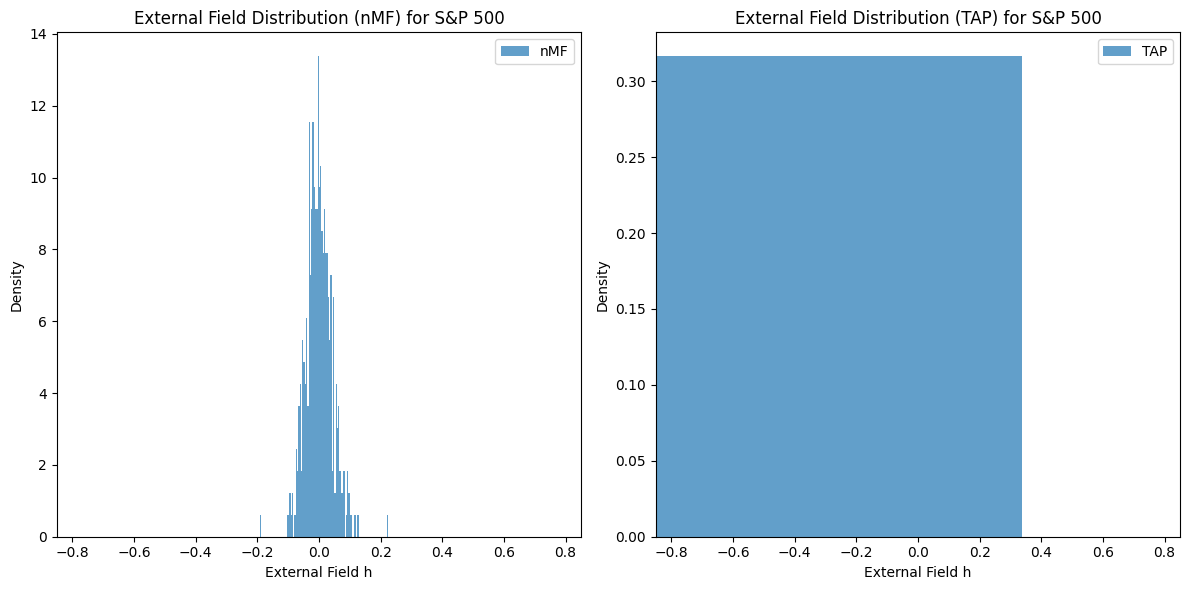

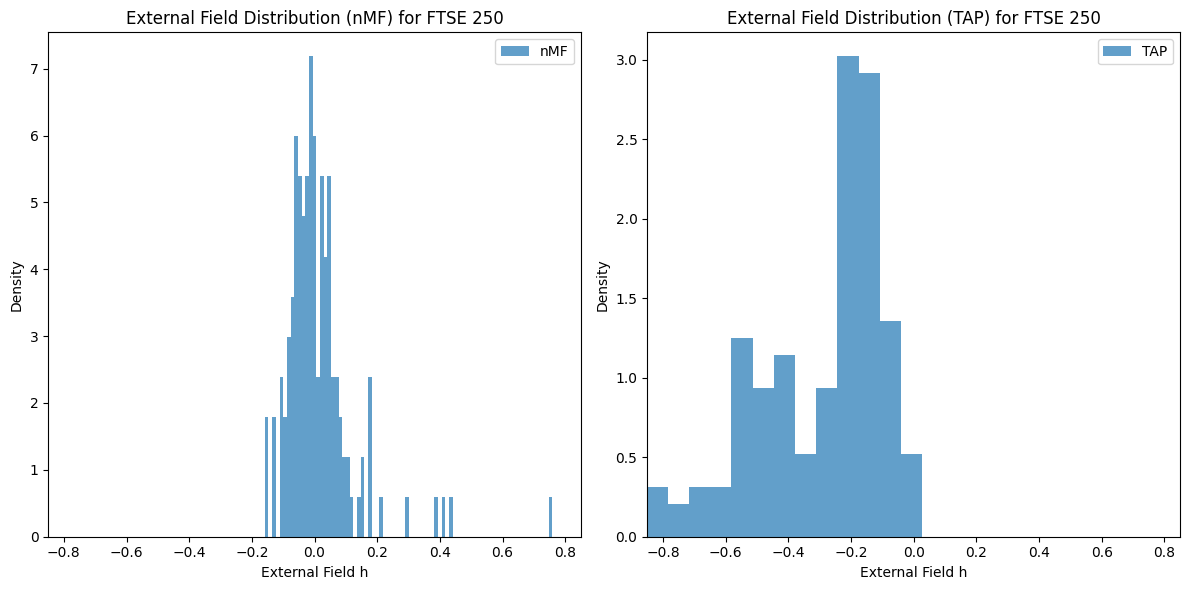

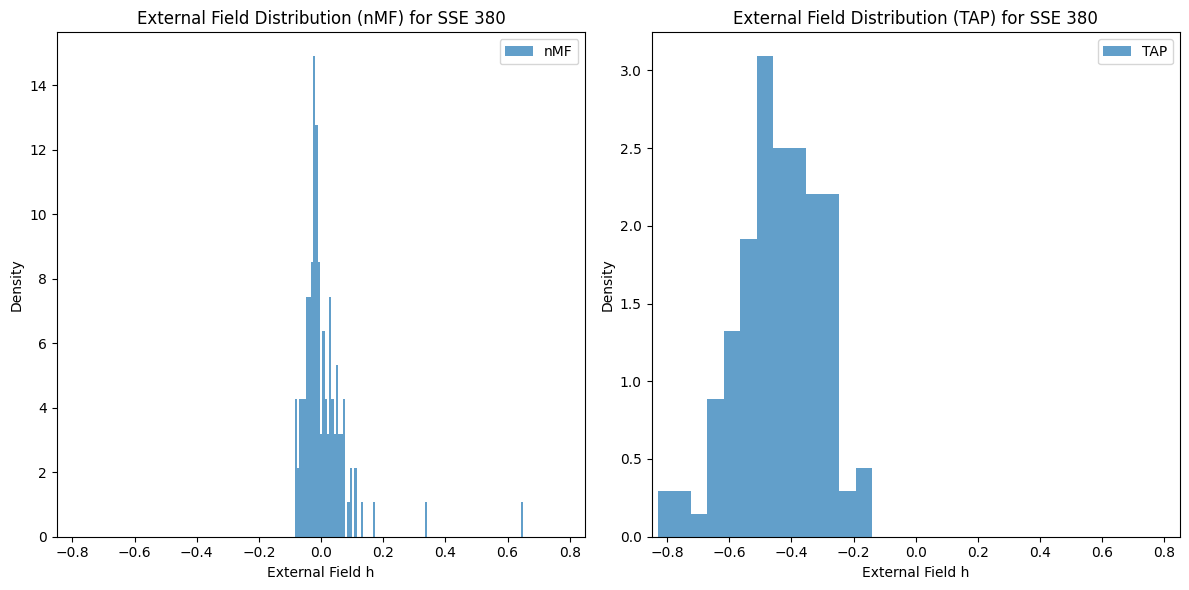

In [17]:
# Iterate over the markets in the results
for name in results.keys():
    # Extract external fields
    h_nMF = results[name]['h_nMF']
    h_TAP = results[name]['h_TAP']
    # For the shuffled data (optional)
    h_nMF_shuffled = results[name]['h_nMF_shuffled']
    h_TAP_shuffled = results[name]['h_TAP_shuffled']
    
    # Plotting the external fields
    plt.figure(figsize=(12, 6))
    # nMF External Fields
    plt.subplot(1, 2, 1)
    plt.hist(h_nMF, bins=100, alpha=0.7, label='nMF', density=True)
    # Optionally plot shuffled data
    # plt.hist(h_nMF_shuffled, bins=100, alpha=0.7, label='Shuffled nMF', density=True)
    plt.title(f"External Field Distribution (nMF) for {name}")
    plt.xlabel("External Field h")
    plt.ylabel("Density")
    plt.xlim(-0.85, 0.85)
    plt.legend()
    
    # TAP External Fields
    plt.subplot(1, 2, 2)
    plt.hist(h_TAP, bins=100, alpha=0.7, label='TAP', density=True)
    # Optionally plot shuffled data
    # plt.hist(h_TAP_shuffled, bins=100, alpha=0.7, label='Shuffled TAP', density=True)
    plt.title(f"External Field Distribution (TAP) for {name}")
    plt.xlabel("External Field h")
    plt.ylabel("Density")
    plt.xlim(-0.85, 0.85)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


### Visualizing the Coupling Strengths

Below we examine the coupling matrices $J_{ij}$ derived from both the nMF and TAP approximations for each market by plotting heatmaps of the interaction strengths between stocks. These coupling strengths reflect the inferred dependencies between pairs of stocks, indicating how the return of one stock may influence or relate to another. By visualizing these matrices, we can identify patterns of strong and weak interactions across the market. Intense colors in the heatmaps highlight pairs of stocks with significant couplings, revealing clusters or sectors with tighter connections. Filtering out extreme values ensures that the visualization focuses on the central distribution of coupling strengths, enhancing interpretability. Comparing the nMF and TAP heatmaps allows us to observe the effects of higher-order corrections on the interaction structure. Overall, these visualizations provide insights into the underlying network of stock interactions, helping us understand the complexity and interconnectedness of financial markets.

Visualizing coupling matrices for S&P 500...
S&P 500 - nMF:
Mean J: 0.006029559353640841
Median J: 0.0037741919151431133
Mode J: -0.900652829410385
Capping values at percentiles: -0.4431, 0.5524


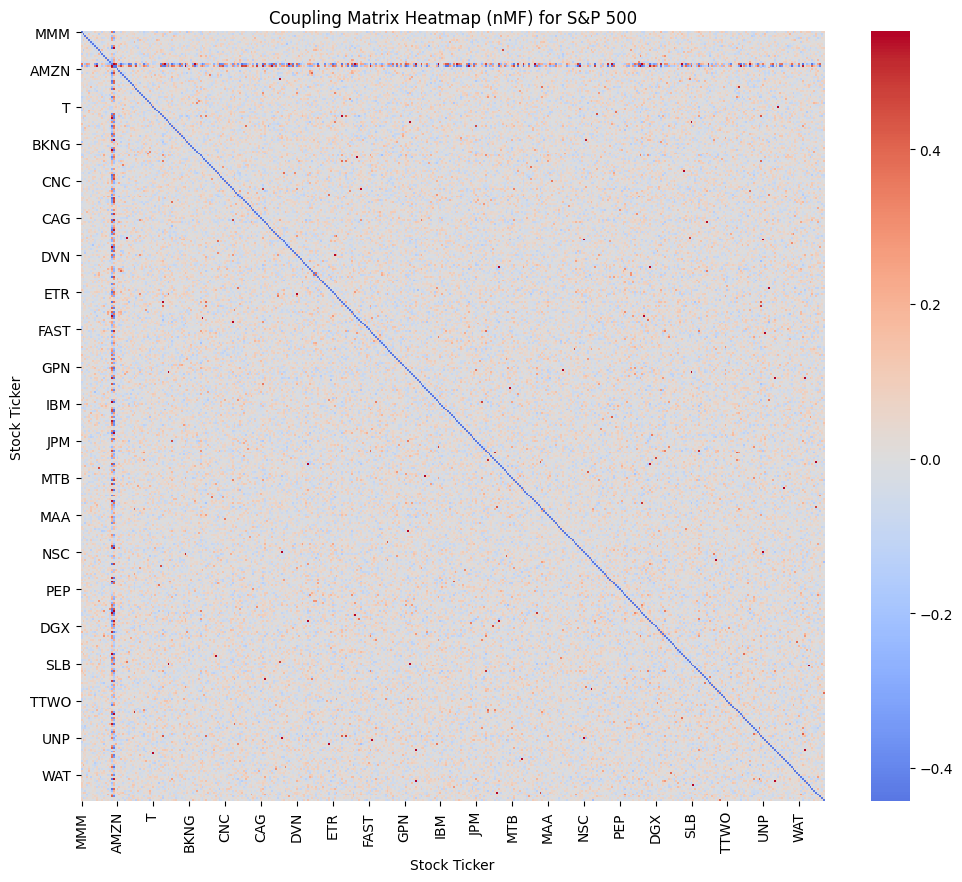

S&P 500 - TAP:
Mean J: 0.005926623158621876
Median J: 0.0037741409370673235
Mode J: -0.9024301032786279
Capping values at percentiles: -0.4436, 0.5517


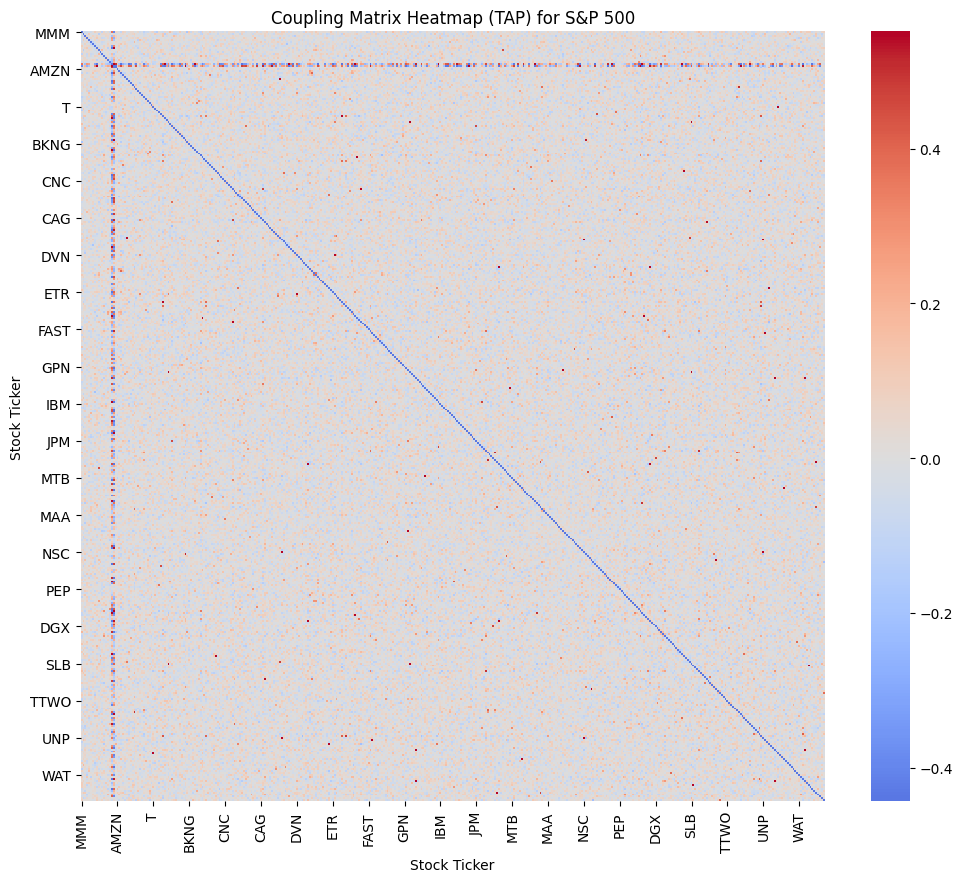

Visualizing coupling matrices for FTSE 250...
FTSE 250 - nMF:
Mean J: 0.009826377582919977
Median J: 0.0073999632973700165
Mode J: -0.16213441278774124
Capping values at percentiles: -0.1336, 0.3236


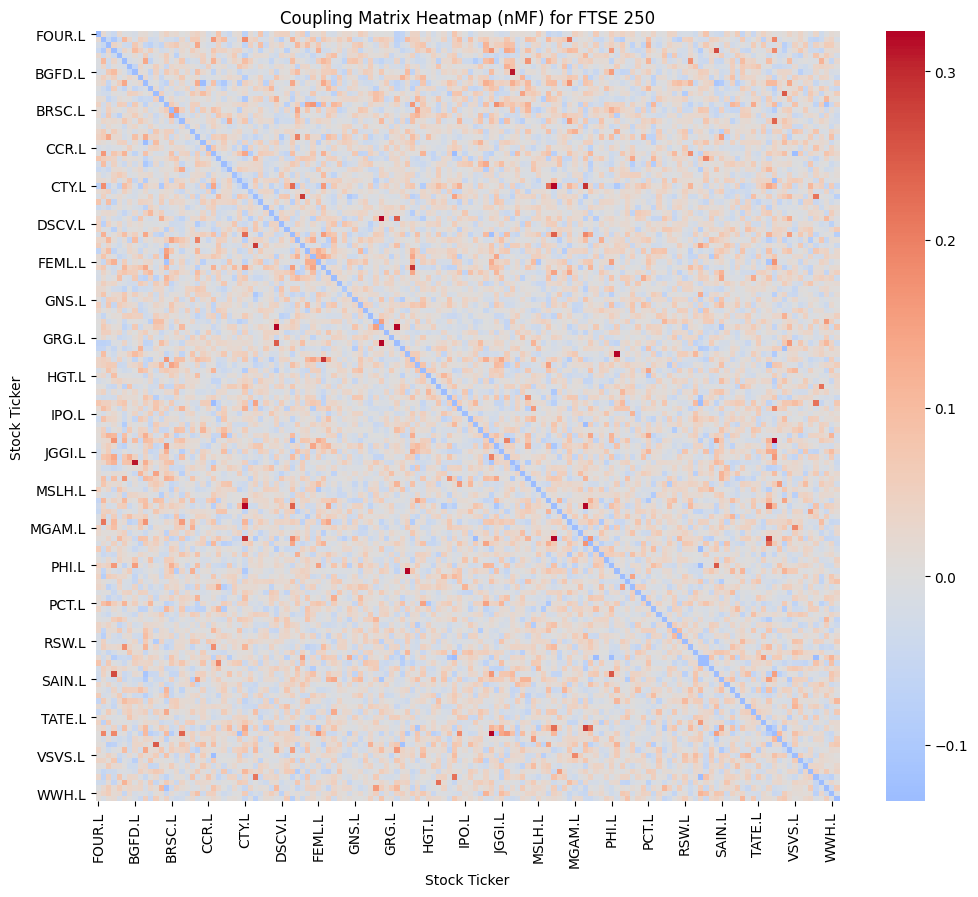

FTSE 250 - TAP:
Mean J: 0.009763915625961217
Median J: 0.007398832087516795
Mode J: -0.1693477762973354
Capping values at percentiles: -0.1343, 0.3232


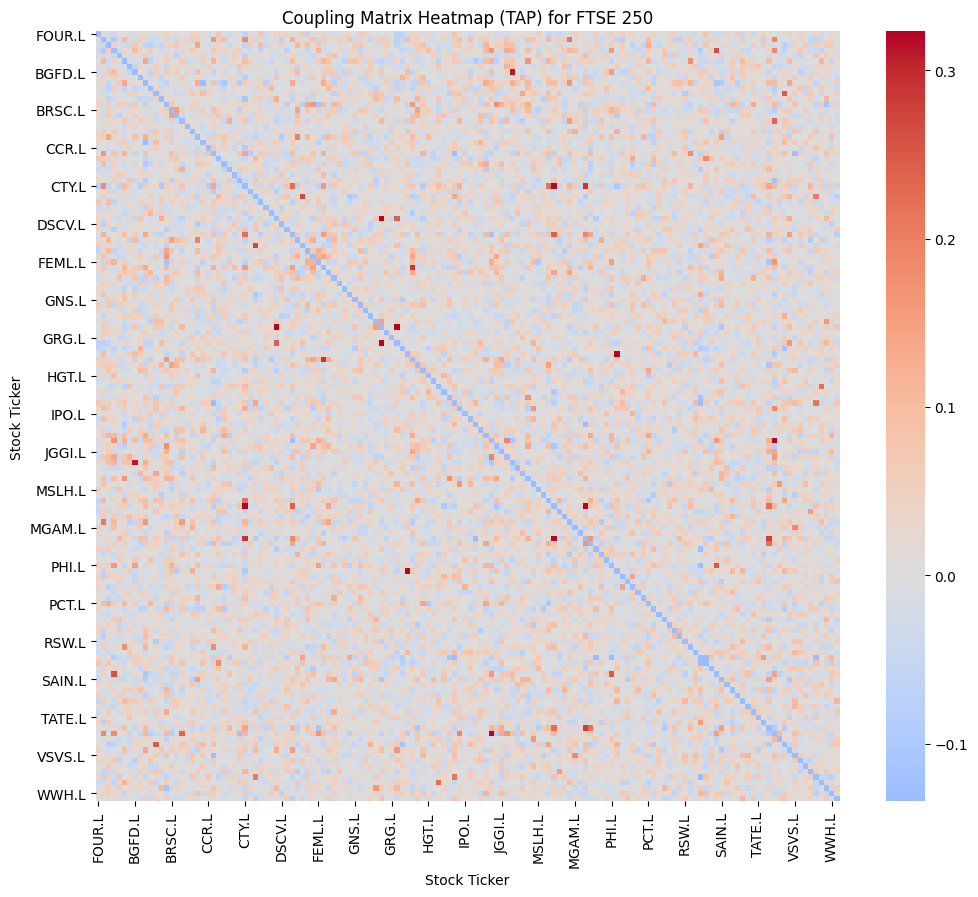

Visualizing coupling matrices for SSE 380...
SSE 380 - nMF:
Mean J: 0.01278860846736575
Median J: 0.009816294189002546
Mode J: -0.15166640074894636
Capping values at percentiles: -0.1329, 0.4291


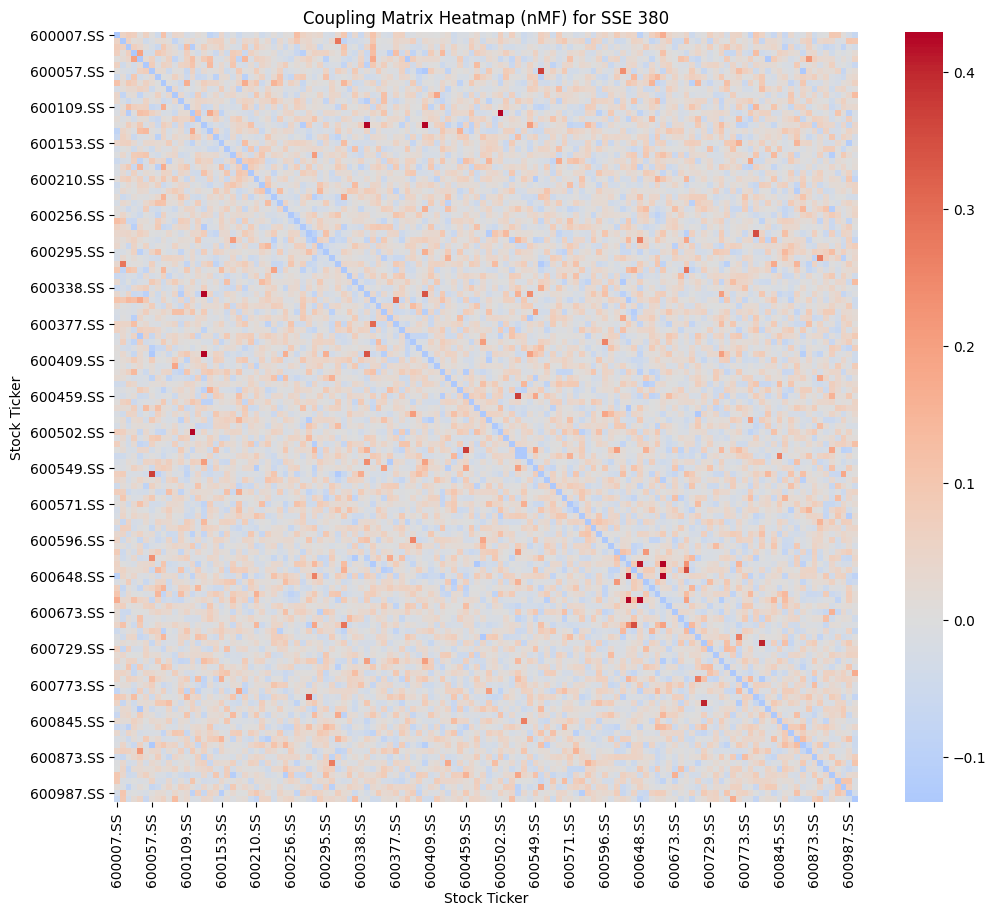

SSE 380 - TAP:
Mean J: 0.01269274375237112
Median J: 0.00981181700079984
Mode J: -0.1551410357526388
Capping values at percentiles: -0.1334, 0.4259


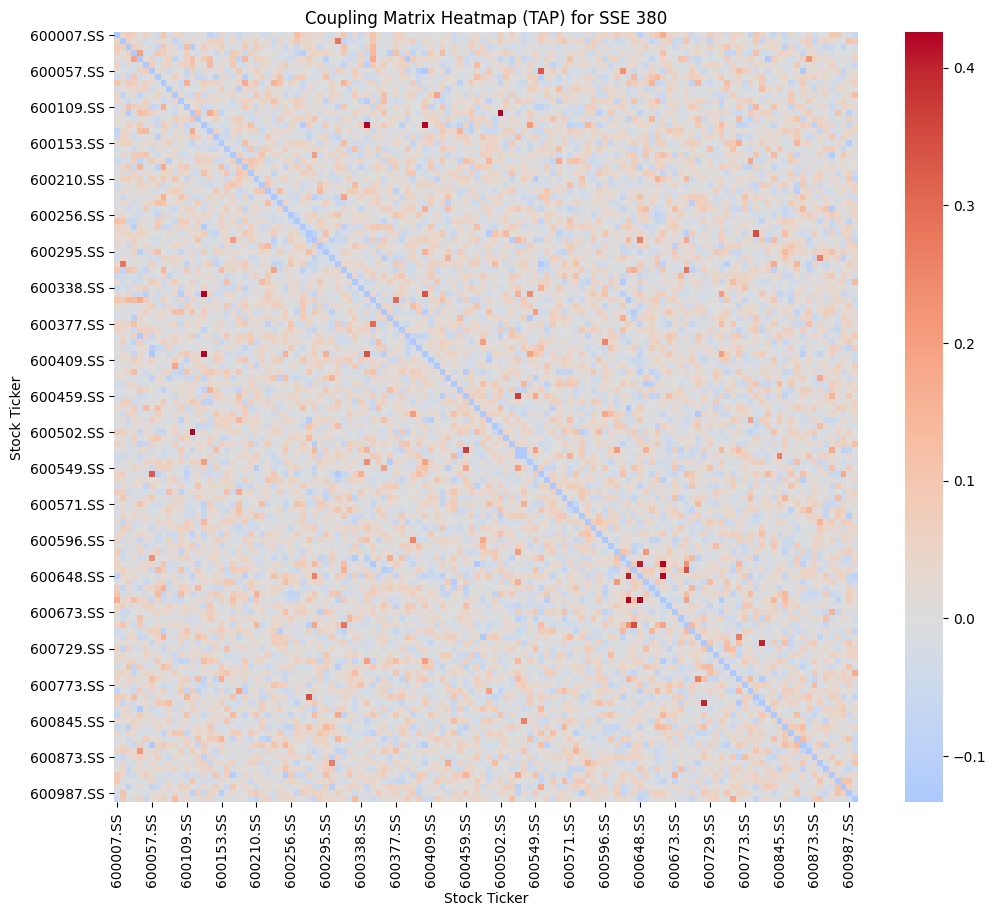

In [22]:
# For each market
for name in results.keys():
    print(f"Visualizing coupling matrices for {name}...")
    # Get the stock tickers from the 's' DataFrame in results
    tickers = results[name]['s'].columns.tolist()
    num_stocks = len(tickers)
    # For each method
    for method in ['nMF', 'TAP']:
        # Extract the coupling matrix
        J_matrix = results[name][f'J_{method}']
        
        # Extract the off-diagonal elements
        off_diagonal_indices = np.triu_indices_from(J_matrix, k=1)
        off_diagonal_elements = J_matrix[off_diagonal_indices]
        
        # Compute statistics
        mean_J = np.mean(off_diagonal_elements)
        median_J = np.median(off_diagonal_elements)
        mode_J = pd.Series(off_diagonal_elements).mode()
        mode_J_value = mode_J.iloc[0] if not mode_J.empty else np.nan
        
        print(f"{name} - {method}:")
        print(f"Mean J: {mean_J}")
        print(f"Median J: {median_J}")
        print(f"Mode J: {mode_J_value}")
        
        # Compute percentiles for capping
        lower_percentile, upper_percentile = np.percentile(off_diagonal_elements, [0.05, 99.95])
        print(f"Capping values at percentiles: {lower_percentile:.4f}, {upper_percentile:.4f}")
        
        # Cap the values in the matrix
        J_matrix_capped = np.clip(J_matrix, lower_percentile, upper_percentile)
        
        # Plot heatmap
        plt.figure(figsize=(12, 10))
        ax = sns.heatmap(J_matrix_capped, cmap="coolwarm", center=0, xticklabels=False, yticklabels=False)
        plt.title(f"Coupling Matrix Heatmap ({method}) for {name}")
        plt.xlabel("Stock Ticker")
        plt.ylabel("Stock Ticker")
        
        # Set tick labels
        if num_stocks <= 50:
            tick_locs = np.arange(num_stocks) + 0.5
            ax.set_xticks(tick_locs)
            ax.set_xticklabels(tickers, rotation=90)
            ax.set_yticks(tick_locs)
            ax.set_yticklabels(tickers, rotation=0)
        else:
            # Set tick labels every N stocks to avoid clutter
            N = max(num_stocks // 20, 1)  # Adjust N to display approximately 20 labels
            tick_locs = np.arange(0, num_stocks, N) + 0.5
            tick_labels = [tickers[i] for i in range(0, num_stocks, N)]
            ax.set_xticks(tick_locs)
            ax.set_xticklabels(tick_labels, rotation=90)
            ax.set_yticks(tick_locs)
            ax.set_yticklabels(tick_labels, rotation=0)
        
        plt.show()
